In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import os
import calendar
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels
import scipy.signal as ss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn import metrics
import datetime
from dateutil import relativedelta
import matplotlib.dates as mdates

In [2]:
class buy_sell_model():
    def __init__(self,datafile,asset_name,covariates,response1,response2,save_filename,
                 train_start_year,train_start_month,train_start_date,train_end_year,train_end_month,train_end_date,
                 test_start_year,test_start_month,test_start_date,test_end_year,test_end_month,test_end_date):
        
        self.datafile= datafile
        self.covariates=covariates
        self.response1=response1
        self.response2=response2
        self.train_start_year=train_start_year
        self.train_start_month=train_start_month
        self.train_start_date=train_start_date
        self.train_end_year=train_end_year
        self.train_end_month=train_end_month
        self.train_end_date=train_end_date
        self.test_start_year=test_start_year
        self.test_start_month=test_start_month
        self.test_start_date=test_start_date
        self.test_end_year=test_end_year
        self.test_end_month=test_end_month
        self.test_end_date=test_end_date
        self.asset_name=asset_name
        self.save_filename=save_filename
        
    def data_measures(self,data_file_name):    
        data=pd.read_csv(data_file_name, parse_dates=True)
        data = data.drop(['Unnamed: 8'], axis=1)
        data['DATE']=pd.to_datetime(data['DATE'])
        data = data.sort_values(['DATE'], ascending=True)
        
        data=data.set_index(['DATE'])
        data['HIGH'] = np.log(data['HIGH'])
        data['LOW'] = np.log(data['LOW'])
        data['log_Volume'] = np.log(data['Volume'])
        data['returns']=(np.log(data['CLOSE']).diff().fillna(0))
        data['CLOSE'] = np.log(data['CLOSE'])
        data['OPEN'] = np.log(data['OPEN'])
        data['monthly_volatility']=data['CLOSE'].rolling(22).std()
        data['weekly_volatility']=data['CLOSE'].rolling(5).std()
        data['intraday_volatility']=data['HIGH']-data['LOW']
        
        data['CLOSE_lag1']=data.CLOSE.shift(1)
        data['CLOSE_lag2']=data.CLOSE.shift(2)

        data['OPEN_lag1']=data.OPEN.shift(1)
        data['OPEN_lag2']=data.OPEN.shift(2)

        data['OI_lag1']=data.OI.shift(1)
        data['OI_lag2']=data.OI.shift(2)

        data['Volume_lag1']= data['Volume'].shift(1)
        data['Volume_lag2']= data['Volume'].shift(2)

        data['log_Volume_lag1']=data['log_Volume'].shift(1)
        data['log_Volume_lag2']=data['log_Volume'].shift(2)

        data['returns_lag1']=data.returns.shift(1)
        data['returns_lag2']=data.returns.shift(2)

        data['monthly_volatility_lag1']=data.monthly_volatility.shift(1)
        data['monthly_volatility_lag2']=data.monthly_volatility.shift(2)

        data['weekly_volatility_lag1']=data.weekly_volatility.shift(1)
        data['weekly_volatility_lag2']=data.weekly_volatility.shift(2)

        data['intraday_volatility_lag1']=data['intraday_volatility'].shift(1)
        data['intraday_volatility_lag2']=data['intraday_volatility'].shift(2)
        
        data_ = data.dropna()
        return data_
    
    def model_returns_and_LogPrice(self,train,test,response1,response2,covariates):
        
        result=pd.DataFrame(index=test.index)
        pred_price=[]
        pred_return=[]
        return_ci=[]
        price_ci=[]
        return_pi=[]
        price_pi=[]
        score=[]
        adj_score=[]
        n1=len(train)
        n2=len(test)
        for date in range(0, n2):
            y_train_1 = train.loc[:, response1].tail(n1)
            y_train_2 = train.loc[:, response2].tail(n1)
            x_train =train.loc[:, covariates].tail(n1)
            X = x_train.values
            return_model = LinearRegression().fit(x_train, y_train_1)
            price_model = LinearRegression().fit(x_train, y_train_2)
            return_mse = metrics.mean_squared_error(y_train_1, return_model.predict(x_train))*(n1-1)/(n1-x_train.shape[1]-1)
            price_mse = metrics.mean_squared_error(y_train_2, price_model.predict(x_train))*(n1-1)/(n1-x_train.shape[1]-1)
            train = pd.concat([train, test.loc[test.index[date]:test.index[date],]])
            train = train.tail(n1)
            y_train_1 = train.loc[:, response1].tail(n1)
            y_train_2 = train.loc[:, response2].tail(n1)
            x_train =train.loc[:, covariates].tail(n1)
            regressor = np.array(x_train.tail(1))
            hat = regressor.dot(np.linalg.inv(X.T.dot(X))).dot(regressor.T)
            return_ci.append(float(np.sqrt(hat*return_mse)))
            return_pi.append(float(np.sqrt((1+hat)*return_mse)))
            price_ci.append(float(np.sqrt(hat*price_mse)))
            price_pi.append(float(np.sqrt((1+hat)*price_mse)))
            pred_return.append(float(return_model.predict(x_train.tail(1))))
            pred_price.append(float(price_model.predict(x_train.tail(1))))
        result['observed_return']=test.loc[:, response1]
        result['pred_return']=pred_return
        result['error_return']=result['observed_return']- result['pred_return']
        result['observed_price']=test.loc[:,response2]
        result['pred_price']=pred_price
        result['error_price']=result['observed_price']-result['pred_price']
        result['return68_low_ci']= np.array(pred_return)-np.array(return_ci)
        result['return68_high_ci']=np.array(pred_return)+np.array(return_ci)
        result['return95_low_ci']=np.array(pred_return)-1.96*np.array(return_ci)
        result['return95_high_ci']=np.array(pred_return)+1.96*np.array(return_ci)
        result['price68_low_ci']=np.array(pred_price)-np.array(price_ci)
        result['price68_high_ci']=np.array(pred_price)+np.array(price_ci)
        result['price95_low_ci']=np.array(pred_price)-1.96*np.array(price_ci)
        result['price95_high_ci']=np.array(pred_price)+1.96*np.array(price_ci)
        result['return68_low_pi']=np.array(pred_return)-np.array(return_pi)
        result['return68_high_pi']=np.array(pred_return)+np.array(return_pi)
        result['price68_low_pi']=np.array(pred_price)-np.array(price_pi)
        result['price68_high_pi']=np.array(pred_price)+np.array(price_pi)
        result['return95_low_pi']=np.array(pred_return)-1.96*np.array(return_pi)
        result['return95_high_pi']=np.array(pred_return)+1.96*np.array(return_pi)
        result['price95_low_pi']=np.array(pred_price)-1.96*np.array(price_pi)
        result['price95_high_pi']=np.array(pred_price)+1.96*np.array(price_pi)
        result['high']=test.loc[:, 'HIGH']
        result['low']=test.loc[:, 'LOW']
        return result
        
    def find_trend(self,trend_index,trend_data, order=1):
        
        coeffs = np.polyfit(trend_index, list(trend_data), order)
        slope = coeffs[-2]
        return float(slope)
        
    def increasing_trend_algo(self,N,dated,low_price,log_price_data,log_price_68_lower_CI,log_price_68_upper_CI,returns_data,avg_returns_data,predicted_log_price_data):
        
        i=0
        j=0
        k=0
        orders_date=[]
        order_type = []
        orders_price = []
        orders_price_absolute_term=[]
        dropdown_in_return = []
        dropdown_in_absolute = []
        low = []
        stop_loss = []
        obs_returns = []
        pred_returns = []
    
        dropdown_relative_measure = np.array(returns_data)-np.array(avg_returns_data)
        return_absolute = np.array(np.exp(log_price_data))*(np.array(np.exp(returns_data))-1)
        avg_return_absolute = np.array(np.exp(predicted_log_price_data))*(np.array(np.exp(avg_returns_data))-1)
        dropdown_absolute_measure = return_absolute - avg_return_absolute
    
        print (len(dropdown_relative_measure), len(return_absolute),len(avg_return_absolute),len(dropdown_absolute_measure))

        while (i <= N):
            print ("iterate at")
            print (log_price_data[i])
            if (i>=j):
                if (log_price_data[i]>log_price_68_upper_CI[(i)] and i<=(N-1)):
                    print ('Buy at') 
                    print (i)
                    print (np.exp(log_price_data[i]))
                    orders_date.append(dated[i])
                    order_type.append('BUY')
                    orders_price_absolute_term.append(np.exp(log_price_data[i]))
                    dropdown_in_absolute.append(0)
                    low.append(low_price[i])
                    stop_loss.append(np.exp(log_price_68_lower_CI[(i)]))
                    obs_returns.append(returns_data[i])
                    pred_returns.append(avg_returns_data[i])
                    if np.exp(log_price_68_lower_CI[(i)])>=low_price[i]:
                        print ('Sell at')
                        print (i)
                        orders_date.append(dated[i])
                        order_type.append('SELL')
                        orders_price_absolute_term.append(np.exp(log_price_68_lower_CI[(i)]))
                        dropdown_in_absolute.append(0)
                        low.append(low_price[i])
                        stop_loss.append(0)
                        obs_returns.append(returns_data[i])
                        pred_returns.append(avg_returns_data[i])
                        next
                    else:    
                        for r in range((i+1),len(returns_data)):
                            if (returns_data[r]>=avg_returns_data[r] and r<=(N-1)):
                                k = i+1
                                print ('not Sell at')
                                print (r)
                                print (np.exp(log_price_data[r]))
                                absolute_dropdown = np.exp(log_price_data[r])-np.exp(log_price_data[r-1])
                                orders_date.append(dated[r])
                                order_type.append('NOT SELL')
                                orders_price_absolute_term.append(np.exp(log_price_data[r]))
                                dropdown_in_absolute.append(absolute_dropdown)
                                low.append(low_price[r])
                                stop_loss.append(np.exp(log_price_68_lower_CI[(r)]))
                                obs_returns.append(returns_data[r])
                                pred_returns.append(avg_returns_data[r])
                                if np.exp(log_price_68_lower_CI[(r)])>=low_price[r]:
                                    print ('Sell at')
                                    print (r)
                                    orders_date.append(dated[r])
                                    order_type.append('SELL')
                                    orders_price_absolute_term.append(np.exp(log_price_68_lower_CI[(r)]))
                                    dropdown_in_absolute.append(absolute_dropdown)
                                    low.append(low_price[r])
                                    stop_loss.append(0)
                                    obs_returns.append(returns_data[r])
                                    pred_returns.append(avg_returns_data[r])
                                    j= r
                                    i = r
                                    break
                                else:    
                                    next
                            elif (returns_data[r]<avg_returns_data[r] and r<=(N-1)):    
                                print ('Sell at')
                                print (r)
                                print (np.exp(log_price_data[r]))
                                absolute_dropdown = np.exp(log_price_data[r])-np.exp(log_price_data[r-1])
                                print ('**** DRAWDOWN MEASURE ****')
                                print (dropdown_relative_measure[r], dropdown_absolute_measure[r], return_absolute[r], absolute_dropdown)
                                orders_date.append(dated[r])
                                order_type.append('SELL')
                                orders_price_absolute_term.append(np.exp(log_price_data[r]))
                                dropdown_in_absolute.append(absolute_dropdown)
                                low.append(low_price[r])
                                stop_loss.append(0)
                                obs_returns.append(returns_data[r])
                                pred_returns.append(avg_returns_data[r])
                                j= r
                                i = r
                                break 
                            elif (r==N):    
                                print ('FORCEFULLY EXIT')
                                print ('Sell at')
                                print (r)
                                print (np.exp(log_price_data[r]))
                                absolute_dropdown = np.exp(log_price_data[r])-np.exp(log_price_data[r-1])
                                orders_date.append(dated[r])
                                order_type.append('SELL')
                                orders_price_absolute_term.append(np.exp(log_price_data[r]))
                                dropdown_in_absolute.append(absolute_dropdown)
                                low.append(low_price[r])
                                stop_loss.append(np.exp(log_price_68_lower_CI[(r)]))
                                obs_returns.append(returns_data[r])
                                pred_returns.append(avg_returns_data[r])
                                j= r
                                i = r
                                break
                else:
                    print ('Not Buy at')
                    print (i)
                    orders_date.append(dated[i])
                    order_type.append('NOT BUY')
                    orders_price_absolute_term.append(np.exp(log_price_data[i]))
                    dropdown_in_absolute.append(0)
                    low.append(low_price[i])
                    stop_loss.append(0)
                    obs_returns.append(returns_data[i])
                    pred_returns.append(avg_returns_data[i])
            i=i+1
            print ('iterate to')
            print (i)
            print('-----------------ITERATE TO NEXT TRADE-----------------')
        
        orders_df = pd.DataFrame()
        orders_df['date']=orders_date
        orders_df['type']=order_type 
        orders_df['absolute_price']=orders_price_absolute_term
        orders_df['dropdown_absolute']=dropdown_in_absolute
        orders_df['low_price']=low
        orders_df['stop_loss']=(stop_loss)
        orders_df['obs_returns']=obs_returns
        orders_df['pred_returns']=pred_returns
        print (orders_df)
    
        return orders_df
        
    def decreasing_trend_algo(self,N,dated,high_price,log_price_data,log_price_68_lower_CI,log_price_68_upper_CI,returns_data,avg_returns_data,predicted_log_price_data):
        
        i=0
        j=0
        k=0
        orders_date=[]
        order_type = []
        orders_price = []
        orders_price_absolute_term = []
        dropdown_in_return = []
        dropdown_in_absolute = []
        high=[]
        stop_loss=[]
        obs_returns=[]
        pred_returns=[]
    
        dropdown_relative_measure = np.array(returns_data)-np.array(avg_returns_data)
        return_absolute = np.array(np.exp(log_price_data))*(np.array(np.exp(returns_data))-1)
        avg_return_absolute = np.array(np.exp(predicted_log_price_data))*(np.array(np.exp(avg_returns_data))-1)
        dropdown_absolute_measure = return_absolute - avg_return_absolute

        print (len(dropdown_relative_measure), len(return_absolute),len(avg_return_absolute),len(dropdown_absolute_measure))
    
        while (i <= N):
            print ("iterate at")
            print (i,j)
            print (log_price_data[i])
            if (i>=j):
                if (log_price_data[i]<log_price_68_lower_CI[(i)] and i<=(N-1)):
                    print ('Sell at') 
                    print (i)
                    orders_date.append(dated[i])
                    order_type.append('SELL')
                    orders_price.append(log_price_data[i])
                    orders_price_absolute_term.append(np.exp(log_price_data[i]))
                    dropdown_in_absolute.append(0)
                    dropdown_in_return.append(0)
                    high.append(high_price[i])
                    stop_loss.append(np.exp(log_price_68_upper_CI[(i)]))
                    obs_returns.append(returns_data[i])
                    pred_returns.append(avg_returns_data[i])
                    if np.exp(log_price_68_upper_CI[(i)])<=high_price[i]:
                        print ('Buy at')
                        print (i)
                        orders_date.append(dated[i])
                        order_type.append('BUY')
                        orders_price_absolute_term.append(np.exp(log_price_68_upper_CI[(i)]))
                        dropdown_in_absolute.append(0)
                        high.append(high_price[i])
                        stop_loss.append(0)
                        obs_returns.append(returns_data[i])
                        pred_returns.append(avg_returns_data[i])
                        next
                    else: 
                        for r in range((i+1),len(returns_data)):
                            print ('checking to---->', r)
                            if (returns_data[r]<=avg_returns_data[r] and r<=(N-1)):
                                k = i+1
                                print ('not Buy at')
                                print (r)
                                absolute_dropdown = np.exp(log_price_data[r])-np.exp(log_price_data[r-1])
                                orders_date.append(dated[r])
                                order_type.append('NOT BUY')
                                orders_price.append(log_price_data[r])
                                orders_price_absolute_term.append(np.exp(log_price_data[r]))
                                dropdown_in_absolute.append(absolute_dropdown)
                                dropdown_in_return.append(dropdown_relative_measure[r])
                                high.append(high_price[r])
                                stop_loss.append(np.exp(log_price_68_upper_CI[(r)]))
                                obs_returns.append(returns_data[r])
                                pred_returns.append(avg_returns_data[r])
                                if np.exp(log_price_68_upper_CI[(r)])<=high_price[r]:
                                    print ('Buy at')
                                    print (r)
                                    orders_date.append(dated[r])
                                    order_type.append('BUY')
                                    orders_price_absolute_term.append(np.exp(log_price_68_upper_CI[(r)]))
                                    dropdown_in_absolute.append(0)
                                    high.append(high_price[r])
                                    stop_loss.append(0)
                                    obs_returns.append(returns_data[r])
                                    pred_returns.append(avg_returns_data[r])
                                    j= r
                                    i = r
                                    break
                                else: 
                                    next
                            elif (returns_data[r]>avg_returns_data[r] and r<=(N-1)):    
                                print ('Buy at')
                                print (r)
                                print (np.exp(log_price_data[r]))
                                absolute_dropdown = np.exp(log_price_data[r])-np.exp(log_price_data[r-1])
                                print ('**** DRAWDOWN MEASURE ****')
                                print (dropdown_relative_measure[r], dropdown_absolute_measure[r], return_absolute[r], absolute_dropdown)
                                orders_date.append(dated[r])
                                order_type.append('BUY')
                                orders_price.append(log_price_data[r])
                                orders_price_absolute_term.append(np.exp(log_price_data[r]))
                                dropdown_in_absolute.append(absolute_dropdown)
                                dropdown_in_return.append(dropdown_relative_measure[r])
                                high.append(high_price[r])
                                stop_loss.append(0)
                                obs_returns.append(returns_data[r])
                                pred_returns.append(avg_returns_data[r])
                                j= r
                                i = r
                                break      
                            elif (r==N):    
                                print ('Buy at')
                                print ('FORCEFULLY EXIT')
                                print (r)
                                absolute_dropdown = np.exp(log_price_data[r])-np.exp(log_price_data[r-1])
                                print ('**** DRAWDOWN MEASURE ****')
                                print (dropdown_relative_measure[r], dropdown_absolute_measure[r], return_absolute[r], absolute_dropdown)
                                orders_date.append(dated[r])
                                order_type.append('BUY')
                                orders_price.append(log_price_data[r])
                                orders_price_absolute_term.append(np.exp(log_price_data[r]))
                                dropdown_in_absolute.append(absolute_dropdown)
                                dropdown_in_return.append(dropdown_relative_measure[r])
                                high.append(high_price[r])
                                stop_loss.append(np.exp(log_price_68_upper_CI[(r)]))
                                obs_returns.append(returns_data[r])
                                pred_returns.append(avg_returns_data[r])
                                j= r
                                i = r
                                break
                else:
                    print ('Not Sell at')
                    print (i)
                    orders_date.append(dated[i])
                    order_type.append('NOT SELL')
                    orders_price.append(log_price_data[i])
                    orders_price_absolute_term.append(np.exp(log_price_data[i]))
                    dropdown_in_absolute.append(0)
                    dropdown_in_return.append(0)
                    high.append(high_price[i])
                    stop_loss.append(0)
                    obs_returns.append(returns_data[i])
                    pred_returns.append(avg_returns_data[i])
            i=i+1
            print ('iterate to')
            print (i)
            print('-----------------ITERATE TO NEXT TRADE-----------------')
        
        orders_df = pd.DataFrame()
        orders_df['date']=orders_date
        orders_df['type']=order_type 
        orders_df['absolute_price']=orders_price_absolute_term
        orders_df['dropdown_absolute']=dropdown_in_absolute
        orders_df['high_price']=high
        orders_df['stop_loss']=(stop_loss)
        orders_df['obs_returns']=obs_returns
        orders_df['pred_returns']=pred_returns
        print (orders_df)
    
        return orders_df
    
    def added_info(self,df_,trend):
        action=[]
        c_loss=[]
        c_p_l=[]
        i=0
        j=0
        k=0
        if trend=='INCREASING':
            print ('INCREASING','-----', len(df_))
            while (i <= len(df_)-1):    
                print (i,'-----',j)
                if (i>=j):  
                    if df_.loc[i,"type"]=='BUY': 
                        print ('LONG OPEN')
                        long_open_cprice=df_.loc[i,"absolute_price"]
                        action.append('OPEN')
                        c_p_l.append('')
                        c_loss.append('')
                        for j in range((i+1),len(df_)):
                            if df_.loc[j,"type"]=='SELL':
                                print ('LONG CLOSED') 
                                long_closed_cprice=df_.loc[j,"absolute_price"]
                                action.append('CLOSED')
                                c_p_l.append(long_closed_cprice-long_open_cprice)
                                c_loss.append('')
                                i = j+1
                                break
                            else:
                                print ('cont')
                                long_closed_cprice=df_.loc[j,"absolute_price"]
                                action.append('')
                                c_p_l.append('')
                                c_loss.append(long_open_cprice-long_closed_cprice)
                                continue
                    else:
                        print ('NO TRADE')
                        action.append('')
                        c_p_l.append('')
                        c_loss.append('')
                        i = i+1                  
                    
        elif trend=='DECREASING': 
            while (i <= len(df_)-1):    
                print (i)
                if (i>=k):
                    if df_.loc[i,"type"]=='SELL':
                        print ('SHORT OPEN')
                        short_open_cprice=df_.loc[i,"absolute_price"]
                        action.append('OPEN')
                        c_p_l.append('')
                        c_loss.append('')
                        for k in range((i+1),len(df_)):
                            if df_.loc[k,"type"]=='BUY':
                                print ('SHORT CLOSED')
                                short_closed_cprice=df_.loc[k,"absolute_price"]
                                action.append('CLOSED')
                                c_p_l.append(short_open_cprice-short_closed_cprice)
                                c_loss.append('')
                                i = k+1
                                break
                            else:
                                print ('cont')
                                short_closed_cprice=df_.loc[k,"absolute_price"]
                                action.append('')
                                c_p_l.append('')
                                c_loss.append(short_closed_cprice-short_open_cprice)
                                continue
                    else:
                        action.append('')
                        c_p_l.append('')
                        c_loss.append('')
                        i = i+1            
       
        print (len(action),len(c_p_l),len(c_loss))
        df_['action']=action
        df_['stock_p_l']=c_p_l
        df_['stock_loss']=c_loss
        return df_    
    
        
    def plot_(self,actualPrice, predPrice, actualReturn, predReturn, priceUp68CI,
                priceLo68CI, priceUp95CI, priceLo95CI,returnUp68CI, returnLo68CI,
                returnUp95CI, returnLo95CI, traded_date, price_type, label, trend, annotation, file_name):

        #print (traded_date)
        Dates=(actualPrice.index)
        plt.plot(np.exp(actualPrice),label = 'Actual'+label+'Stock Price',color='blue',marker='o')
        plt.plot(np.exp(predPrice),label = 'Predicted'+label+'Stock Price',color='green',marker='o')
    
        if price_type=='OPEN':
            if trend=='INCREASE':
                plt.plot(np.exp(priceLo68CI), label='68% LOWER Conf Interval ', color='red')
                plt.plot(np.exp(priceLo68CI), label='STOP LOSS ', color='red', marker='o')
                plt.plot(np.exp(priceUp95CI), label='68% UPPER Conf Interval', color='black')
                plt.plot(np.exp(priceUp95CI), label='TARGET', color='black',marker='o')
            elif trend=='DECREASE': 
                plt.plot(np.exp(priceLo68CI), label='68% LOWER Conf Interval ', color='red')
                plt.plot(np.exp(priceLo68CI), label='TARGET', color='red',marker='o')
                plt.plot(np.exp(priceUp95CI), label='STOP LOSS', color='black',marker='o')
                plt.plot(np.exp(priceUp95CI), label='68% UPPER Conf Interval', color='black')
        elif price_type=='CLOSE':
            if trend=='INCREASE':
                plt.plot(np.exp(priceLo68CI), label='68% LOWER Conf Interval ', color='red')
                plt.plot(np.exp(priceLo68CI), label='STOP LOSS ', color='red', marker='o')
                plt.plot(np.exp(priceUp68CI), label='68% UPPER Conf Interval', color='black')
                plt.plot(np.exp(priceUp68CI), label='TARGET', color='black',marker='o')
            elif trend=='DECREASE': 
                plt.plot(np.exp(priceLo68CI), label='68% LOWER Conf Interval ', color='red')
                plt.plot(np.exp(priceLo68CI), label='TARGET ', color='red', marker='o')
                plt.plot(np.exp(priceUp68CI), label='68% UPPER Conf Interval', color='black')
                plt.plot(np.exp(priceUp68CI), label='STOP LOSS', color='black',marker='o')       
    
        if annotation=='True':
            for x,y,z,u,p,v,w in zip(Dates,np.exp(actualPrice),np.exp(predPrice),np.exp(priceUp68CI),np.exp(priceLo68CI),np.exp(priceLo95CI),np.exp(priceUp95CI)):
                if x in traded_date:
                    print (x)
                    labely = "{:.4f}".format(y)
                    labelz = "{:.4f}".format(z)
                    labelu = "{:.4f}".format(u)
                    labelp = "{:.4f}".format(p)
                    labelv = "{:.4f}".format(v)
                    labelw = "{:.4f}".format(w)
                    if trend=='INCREASE':
                        plt.annotate(labely, # this is the text
                         (x,y), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,4), # distance from text to points (x,y)
                         size=8,
                         color='blue',  
                         ha='center')
                        plt.annotate(labelz, # this is the text
                         (x,z), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,4), # distance from text to points (x,y)
                         size=8,
                         color='green',    
                         ha='center')
                        plt.annotate(labelz, # this is the text
                         (x,u), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,8), # distance from text to points (x,y)
                         size=8,
                         color='red',    
                         ha='center')
                        plt.annotate(labelz, # this is the text
                         (x,v), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,4), # distance from text to points (x,y)
                         size=8,
                         color='black',    
                         ha='center')
                    elif trend=='DECREASE': 
                        plt.annotate(labely, # this is the text
                         (x,y), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,4), # distance from text to points (x,y)
                         size=8,
                         color='blue',  
                         ha='center')
                        plt.annotate(labelz, # this is the text
                         (x,z), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,8), # distance from text to points (x,y)
                         size=8,
                         color='green',    
                         ha='center')
                        plt.annotate(labelz, # this is the text
                         (x,p), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,4), # distance from text to points (x,y)
                         size=8,
                         color='red',    
                         ha='center')
                        plt.annotate(labelz, # this is the text
                         (x,w), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,4), # distance from text to points (x,y)
                         size=8,
                         color='black',    
                         ha='center')
        plt.yticks(np.arange(min(np.exp(priceLo95CI)), max(np.exp(priceUp95CI)), step=300))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.title(label+'Stock_'+price_type+'_Price Prediction')
        plt.xlabel('Date')
        plt.ylabel(label+'_'+price_type+'_Stock Price')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=90)        
        fig = plt.gcf()
        fig.set_size_inches(16.5, 8.5)
        fig.savefig(self.save_filename+'_'+file_name+'_Log_'+price_type+'_Price.png', dpi=100)
        plt.show()
        plt.plot(actualReturn,label = 'Actual'+label+'Stock return')
        plt.plot(predReturn,label = 'Predicted'+label+'Stock return')
        plt.title(label+'Stock Return Prediction')
        plt.xlabel('Date')
        plt.ylabel(label+'Stock Return')
        plt.plot(returnUp68CI, label='68% Conf Interval', color='red')
        plt.plot(returnLo68CI, color='red')
        plt.plot(returnUp95CI, label='95% Conf Interval', color='black')
        plt.plot(returnLo95CI, color='black')
        plt.legend()
        plt.xticks(rotation=90)
        fig = plt.gcf()
        fig.set_size_inches(18.5, 8.5)
        fig.savefig(self.save_filename+'_'+file_name+'_Log_'+price_type+'to_Log_Return.png', dpi=100)
        plt.show()
        
    def find_results(self,number_of_windows):
    
        trade_algo_result=pd.DataFrame()
        train_time_period =[]
        test_time_period =[]
        P_L=[]
        number_of_trades=[]
        P_L_amount=[]
        P_L_amount_absolute_term=[]
        trend=[]
        buy_sell_info=[]
        
        xlsx_filename = self.save_filename+"_"+asset_name+str(covariates)+'_'+response2+'_model'+'_with_'+str(number_of_windows)+'_windows'+'.xlsx'
        data=self.data_measures(self.datafile)
        
        train_start_now = date(self.train_start_year,self.train_start_month,self.train_start_date)
        train_end_now = date(self.train_end_year,self.train_end_month,self.train_end_date)
        test_start_now = date(self.test_start_year,self.test_start_month,self.test_start_date)
        test_end_now = date(self.test_end_year,self.test_end_month,self.test_end_date) 
        
        writer = pd.ExcelWriter(xlsx_filename,engine='xlsxwriter')
        for i in range(0,number_of_windows): 
            train_data_period = str(train_start_now)+':'+str(train_end_now)
            test_data_period = str(test_start_now)+'to'+str(test_end_now) 
            print (train_data_period, test_data_period)
            train_time_period.append(train_data_period)
            test_time_period.append(test_data_period)
        
            train_data, test_data = data.loc[str(train_start_now):str(train_end_now),], data.loc[str(test_start_now):str(test_end_now) ,] 
            sheet_name = str(test_start_now)+'to'+str(test_end_now)
            label=self.asset_name+'_'+self.response2
            plot_filename=sheet_name+'_'
            result=self.model_returns_and_LogPrice(train_data, test_data, response1, response2, covariates)
            
            dated=list(result.index.date)
            log_price_data=list(result.observed_price)
            pred_log_price_data=list(result.pred_price)
            log_price_68_lower_CI=list(result.price68_low_ci)
            log_price_68_upper_CI=list(result.price68_high_ci)
            log_price_95_lower_CI=list(result.price95_low_ci)
            log_price_95_upper_CI=list(result.price95_high_ci)
            log_price_68_lower_PI=list(result.price68_low_pi)
            log_price_68_upper_PI=list(result.price68_high_pi)
            log_price_95_lower_PI=list(result.price95_low_pi)
            log_price_95_upper_PI=list(result.price95_high_pi)
            returns_data=list(result.observed_return)
            avg_returns_data=list(result.pred_return)
            high_price = np.exp(list(result.high))
            low_price = np.exp(list(result.low))
        
            train_start_days_in_month = calendar.monthrange(train_start_now.year, train_start_now.month)[1]
            train_start_now = train_start_now + timedelta(days=train_start_days_in_month)
            train_end_days_in_month = calendar.monthrange(train_end_now.year, train_end_now.month)[1]
            train_end_now = train_end_now + timedelta(days=train_end_days_in_month)
        
            test_start_days_in_month = calendar.monthrange(test_start_now.year, test_start_now.month)[1]
            test_start_now = test_start_now + timedelta(days=test_start_days_in_month)
            test_end_days_in_month = calendar.monthrange(test_end_now.year, test_end_now.month)[1]
            test_end_now = test_end_now + timedelta(days=test_end_days_in_month)
        
            index= list(range(0,len(result)))
            List= result.pred_price
            resultent=self.find_trend(index,List) 
        
            algo_df = pd.DataFrame()
            algo_df['log_price_data']=log_price_data
            algo_df['pred_log_price_data']=pred_log_price_data
            algo_df['log_price_68_lower_CI']=log_price_68_lower_CI 
            algo_df['log_price_68_upper_CI']=log_price_68_upper_CI
            algo_df['log_price_95_lower_CI']=log_price_95_lower_CI 
            algo_df['log_price_95_upper_CI']=log_price_95_upper_CI
            algo_df['log_price_68_lower_PI']=log_price_68_lower_PI 
            algo_df['log_price_68_upper_PI']=log_price_68_upper_PI
            algo_df['log_price_95_lower_PI']=log_price_95_lower_PI 
            algo_df['log_price_95_upper_PI']=log_price_95_upper_PI
            algo_df['returns_data']=returns_data
            algo_df['avg_returns_data']=avg_returns_data
        
            if (len(log_price_data)==len(returns_data)):
                print('length matched')
                N= len(log_price_data)-1
                print(N)
            
                if resultent>0:
                    print ('INCREASING TREND')
                    trend.append('INCREASING TREND')
                    if self.response2=='OPEN':
                        #label=self.asset_name+'_'+self.response2+'_'
                        orders_df=self.increasing_trend_algo(N,dated,low_price,log_price_data,log_price_68_lower_PI,log_price_68_upper_CI,returns_data,avg_returns_data,pred_log_price_data)
                        added_orders_df=self.added_info(orders_df,'INCREASING')
                        print ('----ADDED DF----')
                        print (added_orders_df)
                        trade_lists=list(added_orders_df[added_orders_df['action']!='']['date'])
                        print ('TRADED_DATE_LISTS')
                        print (trade_lists)
                        self.plot_(result.observed_price,result.pred_price,result.observed_return,result.pred_return,
                          result.price68_high_ci,result.price68_low_ci,result.price68_high_pi,result.price68_low_pi,
                          result.return68_high_ci,result.return68_low_ci,result.return95_high_ci,result.return95_low_ci,trade_lists,self.response2,label,'INCREASE','True',plot_filename)
                        added_orders_df.to_excel(writer, sheet_name)
                    elif self.response2=='CLOSE':
                        #label=self.asset_name+'_'+self.response2+'_'
                        orders_df=self.increasing_trend_algo(N,dated,low_price,log_price_data,log_price_68_lower_PI,log_price_68_upper_PI,returns_data,avg_returns_data,pred_log_price_data)
                        added_orders_df=self.added_info(orders_df,'INCREASING')
                        print ('----ADDED DF----')
                        print (added_orders_df)
                        trade_lists=list(added_orders_df[added_orders_df['action']!='']['date'])
                        print ('TRADED_DATE_LISTS')
                        print (trade_lists)
                        self.plot_(result.observed_price,result.pred_price,result.observed_return,result.pred_return,
                          result.price68_high_pi,result.price68_low_pi,result.price68_high_pi,result.price68_low_pi,
                          result.return68_high_ci,result.return68_low_ci,result.return95_high_ci,result.return95_low_ci,trade_lists,self.response2,label,'INCREASE','True',plot_filename)
                        added_orders_df.to_excel(writer, sheet_name)
                    print (orders_df)
                    added_orders_df=self.added_info(orders_df,'INCREASING')
                    print ('----ADDED DF----')
                    print (added_orders_df)
                    filename = str(test_data_period)+'.csv'
                    orders_df.to_csv(filename)
                elif resultent<0:
                    print ('DECREASING TREND')
                    trend.append('DECREASING TREND')
                    if self.response2=='OPEN':
                        #label=self.asset_name+'_'+self.response2+'_'
                        orders_df=self.decreasing_trend_algo(N,dated,high_price,log_price_data,log_price_68_upper_CI,log_price_68_lower_PI,returns_data,avg_returns_data,pred_log_price_data)
                        added_orders_df=self.added_info(orders_df,'DECREASING')
                        print ('----ADDED DF----')
                        print (added_orders_df)
                        trade_lists=list(added_orders_df[added_orders_df['action']!='']['date'])
                        print ('TRADED_DATE_LISTS')
                        print (trade_lists)
                        self.plot_(result.observed_price,result.pred_price,result.observed_return,result.pred_return,
                          result.price68_high_ci,result.price68_low_ci,result.price68_high_pi,result.price68_low_pi,
                          result.return68_high_ci,result.return68_low_ci,result.return95_high_ci,result.return95_low_ci,trade_lists,self.response2,label,'DECREASE','True',plot_filename)
                        added_orders_df.to_excel(writer, sheet_name)
                    elif self.response2=='CLOSE':
                        #label=self.asset_name+'_'+self.response2+'_'
                        orders_df=self.decreasing_trend_algo(N,dated,high_price,log_price_data,log_price_68_upper_PI,log_price_68_lower_PI,returns_data,avg_returns_data,pred_log_price_data)
                        added_orders_df=self.added_info(orders_df,'DECREASING')
                        print ('----ADDED DF----')
                        print (added_orders_df)
                        trade_lists=list(added_orders_df[added_orders_df['action']!='']['date'])
                        print ('TRADED_DATE_LISTS')
                        print (trade_lists)
                        self.plot_(result.observed_price,result.pred_price,result.observed_return,result.pred_return,
                          result.price68_high_pi,result.price68_low_pi,result.price68_high_pi,result.price68_low_pi,
                          result.return68_high_ci,result.return68_low_ci,result.return95_high_ci,result.return95_low_ci,trade_lists,self.response2,label,'DECREASE','True',plot_filename)
                        added_orders_df.to_excel(writer, sheet_name)
                    print (orders_df)
                    added_orders_df=self.added_info(orders_df,'DECREASING')
                    print ('----ADDED DF----')
                    print (added_orders_df)
                    filename = str(test_data_period)+'.csv'
                    orders_df.to_csv(filename)
                
                print (orders_df.head(2))
                buy=orders_df[orders_df.type =='BUY']
                #buying_after_Selling = sum(buy.price)
                buying_after_Selling_absolute_term=sum(buy.absolute_price)
                print (buying_after_Selling_absolute_term)
                print (len(buy))
            
                sell=orders_df[orders_df.type =='SELL']
                #selling = sum(sell.price)
                selling_absolute_term=sum(sell.absolute_price)
                print (selling_absolute_term)
                print (len(sell))
            
                if len(sell)==len(buy):
                    number_of_trades.append(len(sell))
                
                #p_l=selling-buying_after_Selling
                p_l_absolute_term=selling_absolute_term-buying_after_Selling_absolute_term
                if (p_l_absolute_term<0):
                    print('LOSS OF')
                    print (p_l_absolute_term)
                    P_L.append('LOSS')
                    #P_L_amount.append(p_l)
                    P_L_amount_absolute_term.append(p_l_absolute_term)
                else:
                    print('PROFIT 0F')
                    print (p_l_absolute_term)
                    P_L.append('PROFIT')
                    #P_L_amount.append(p_l)
                    P_L_amount_absolute_term.append(p_l_absolute_term)

            ##print (buy.columns, sell.columns)    
                
            print ('--------------------------------------------------------------------------------------------------------------')            
        trade_algo_result['train_time_period ']=train_time_period 
        trade_algo_result['test_time_period']=test_time_period
        trade_algo_result['P_L']=P_L
        trade_algo_result['number_of_trades']=number_of_trades
        #trade_algo_result['P_L_amount']=P_L_amount
        trade_algo_result['P_L_amount_absolute_term']=P_L_amount_absolute_term
        trade_algo_result['trend']=trend
        #trade_algo_result['buy_sell_info']=buy_sell_info
        
        details_dataframe_index=range(0,number_of_windows)
        pd.DataFrame(trade_algo_result,index=details_dataframe_index).to_excel(writer, 'DETAILS')
        writer.save()    

        return trade_algo_result        

In [8]:
datafile='C:/Users/Pal/Documents/ts_model_fittings/Nifty50/NSE BANKNIFTY 26DEC2019_10yrs.csv'
asset_name='NIFTYBANK_'
covariates=['CLOSE_lag1','Volume_lag1','monthly_volatility_lag1']
response1='returns'
response2='OPEN'
save_filename='NIFTYBANK_BUYSELL_ALGO_'
train_start_year=2016
train_start_month=12
train_start_date=11

train_end_year=2018
train_end_month=12
train_end_date=11

test_start_year=2018
test_start_month=12
test_end_year=2019

test_end_month=1
test_start_date=12
test_end_date=11

In [9]:
algo=buy_sell_model(datafile,asset_name,covariates,response1,response2,save_filename,
                 train_start_year,train_start_month,train_start_date,train_end_year,train_end_month,train_end_date,
                 test_start_year,test_start_month,test_start_date,test_end_year,test_end_month,test_end_date)

In [10]:
vars(algo)

{'datafile': 'C:/Users/Pal/Documents/ts_model_fittings/Nifty50/NSE BANKNIFTY 26DEC2019_10yrs.csv',
 'covariates': ['CLOSE_lag1', 'Volume_lag1', 'monthly_volatility_lag1'],
 'response1': 'returns',
 'response2': 'OPEN',
 'train_start_year': 2016,
 'train_start_month': 12,
 'train_start_date': 11,
 'train_end_year': 2018,
 'train_end_month': 12,
 'train_end_date': 11,
 'test_start_year': 2018,
 'test_start_month': 12,
 'test_start_date': 12,
 'test_end_year': 2019,
 'test_end_month': 1,
 'test_end_date': 11,
 'asset_name': 'NIFTYBANK_',
 'save_filename': 'NIFTYBANK_BUYSELL_ALGO_'}

2016-12-11:2018-12-11 2018-12-12to2019-01-11
length matched
21
INCREASING TREND
22 22 22 22
iterate at
10.179217861353685
Buy at
0
26349.849999999995
not Sell at
1
26867.649999999983
Sell at
2
26852.99999999998
**** DRAWDOWN MEASURE ****
-0.0003156399287688322 -8.48310592258865 -3.1964230249338543 -14.650000000001455
iterate to
3
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.203177244112187
Buy at
3
26988.800000000017
not Sell at
4
26950.000000000022
Sell at
4
iterate to
5
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.214678610538817
Buy at
5
27300.999999999978
Sell at
6
27189.400000000023
**** DRAWDOWN MEASURE ****
-0.0005028229375811516 -13.642637053457186 -17.541131618908317 -111.59999999995489
iterate to
7
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.21464198117305
Not Buy at
7
iterate to
8
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.20081050202459
Not Buy at
8
iterate to
9
----------

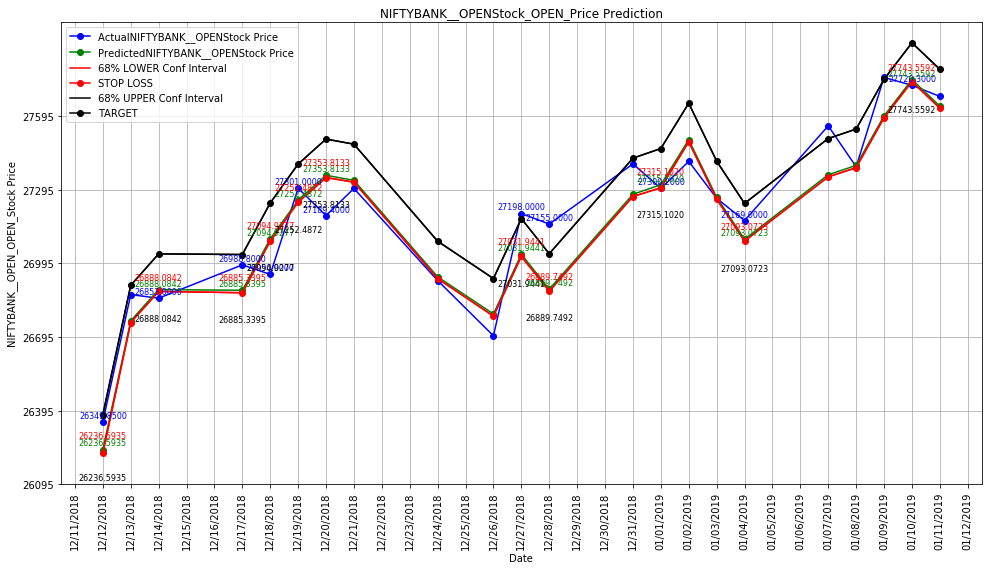

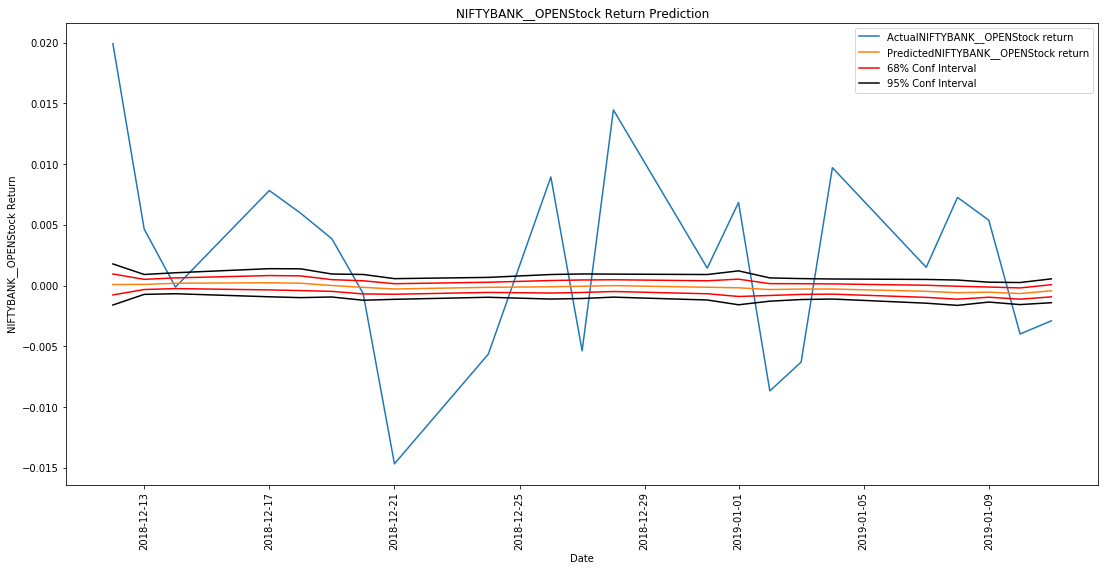

          date      type  absolute_price  dropdown_absolute  low_price  \
0   2018-12-12       BUY    26349.850000               0.00   26297.00   
1   2018-12-13  NOT SELL    26867.650000             517.80   26785.75   
2   2018-12-14      SELL    26853.000000             -14.65   26770.00   
3   2018-12-17       BUY    26988.800000               0.00   26912.15   
4   2018-12-18  NOT SELL    26950.000000             -38.80   26926.35   
5   2018-12-18      SELL    26949.676314             -38.80   26926.35   
6   2018-12-19       BUY    27301.000000               0.00   27271.00   
7   2018-12-20      SELL    27189.400000            -111.60   27155.00   
8   2018-12-21   NOT BUY    27300.000000               0.00   26888.60   
9   2018-12-24   NOT BUY    26925.000000               0.00   26737.10   
10  2018-12-26   NOT BUY    26700.000000               0.00   26439.60   
11  2018-12-27       BUY    27198.000000               0.00   26860.00   
12  2018-12-27      SELL    26887.3609

length matched
20
DECREASING TREND
21 21 21 21
iterate at
0 0
10.220667745776721
Sell at
0
Buy at
0
iterate to
1
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
1 0
10.218685078878487
Not Sell at
1
iterate to
2
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
2 0
10.22317688362289
Sell at
2
Buy at
2
iterate to
3
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
3 0
10.224204175927047
Sell at
3
Buy at
3
iterate to
4
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
4 0
10.227377390307414
Not Sell at
4
iterate to
5
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
5 0
10.224122539349462
Sell at
5
Buy at
5
iterate to
6
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
6 0
10.222713712527382
Sell at
6
Buy at
6
iterate to
7
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
7 0
10.220558509881696
Sell at
7
Buy at
7
iterate to
8
-----------------ITERATE TO NEXT TRADE------

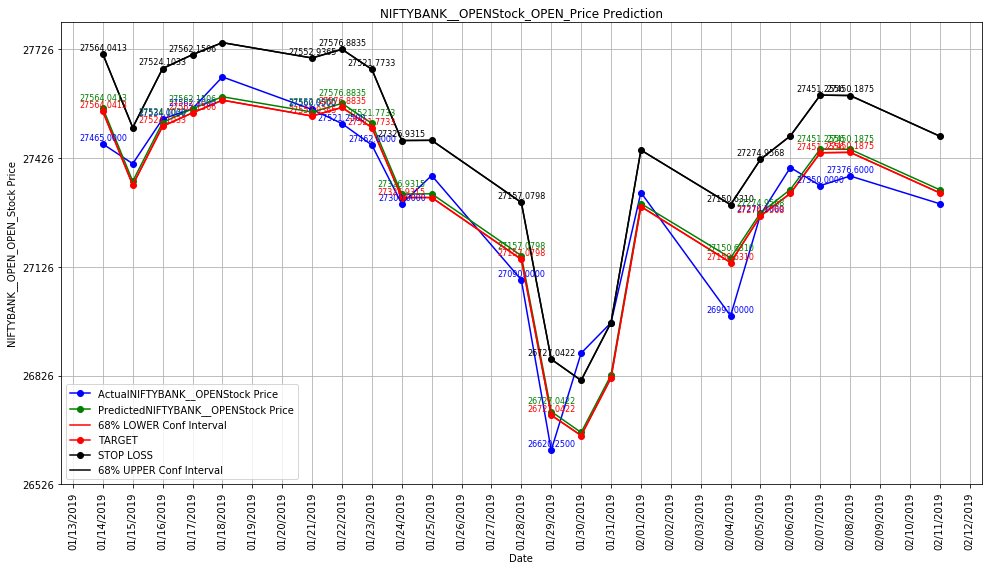

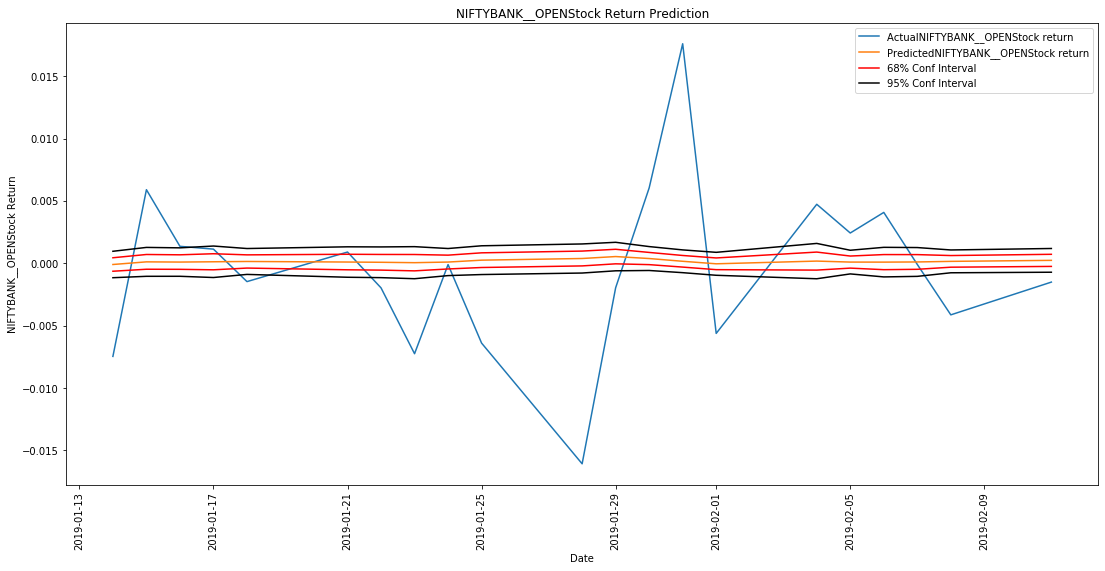

          date      type  absolute_price  dropdown_absolute  high_price  \
0   2019-01-14      SELL    27465.000000                  0    27489.95   
1   2019-01-14       BUY    27415.753242                  0    27489.95   
2   2019-01-15  NOT SELL    27410.600000                  0    27539.00   
3   2019-01-16      SELL    27534.000000                  0    27640.00   
4   2019-01-16       BUY    27375.930395                  0    27640.00   
5   2019-01-17      SELL    27562.300000                  0    27667.35   
6   2019-01-17       BUY    27413.693132                  0    27667.35   
7   2019-01-18  NOT SELL    27649.900000                  0    27676.00   
8   2019-01-21      SELL    27560.050000                  0    27674.95   
9   2019-01-21       BUY    27404.584067                  0    27674.95   
10  2019-01-22      SELL    27521.250000                  0    27560.00   
11  2019-01-22       BUY    27428.432639                  0    27560.00   
12  2019-01-23      SELL 

length matched
18
INCREASING TREND
19 19 19 19
iterate at
10.212394035189236
Not Buy at
0
iterate to
1
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.210972252284089
Buy at
1
27200.0
Sell at
1
iterate to
2
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.202387716249584
Not Buy at
2
iterate to
3
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.206183229669811
Not Buy at
3
iterate to
4
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.195410619245164
Not Buy at
4
iterate to
5
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.194289752324153
Not Buy at
5
iterate to
6
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.196306409093062
Buy at
6
26804.000000000004
not Sell at
7
27059.9
Sell at
8
27049.9
**** DRAWDOWN MEASURE ****
-0.006753851172748543 -182.1915107440239 -169.6409618864518 -10.0
iterate to
9
-----------------ITERATE TO NEXT TRADE-----------------
iterate

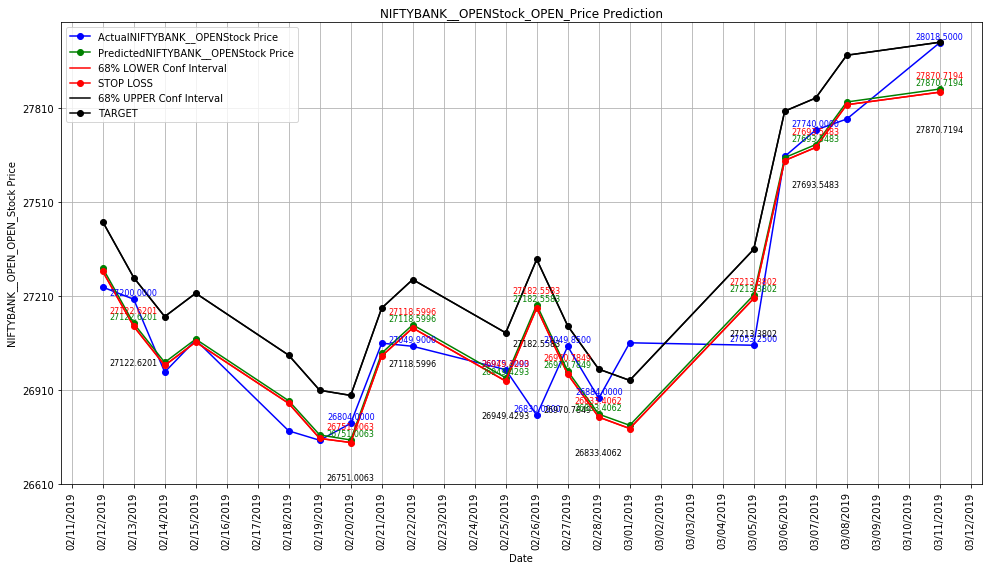

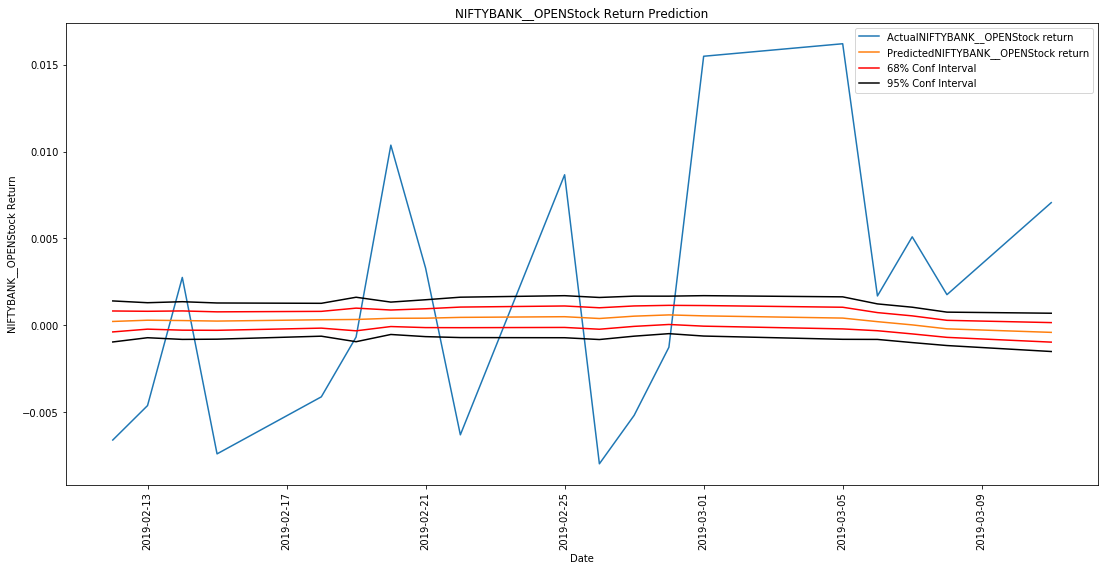

          date      type  absolute_price  dropdown_absolute  low_price  \
0   2019-02-12   NOT BUY    27238.700000               0.00   27086.00   
1   2019-02-13       BUY    27200.000000               0.00   26950.00   
2   2019-02-13      SELL    26976.725205               0.00   26950.00   
3   2019-02-14   NOT BUY    26967.500000               0.00   26912.00   
4   2019-02-15   NOT BUY    27070.050000               0.00   26721.00   
5   2019-02-18   NOT BUY    26780.000000               0.00   26722.00   
6   2019-02-19   NOT BUY    26750.000000               0.00   26700.00   
7   2019-02-20       BUY    26804.000000               0.00   26730.15   
8   2019-02-21  NOT SELL    27059.900000             255.90   27038.45   
9   2019-02-22      SELL    27049.900000             -10.00   26915.05   
10  2019-02-25       BUY    26975.300000               0.00   26950.10   
11  2019-02-26      SELL    26830.000000            -145.30   26740.00   
12  2019-02-27       BUY    27049.8500

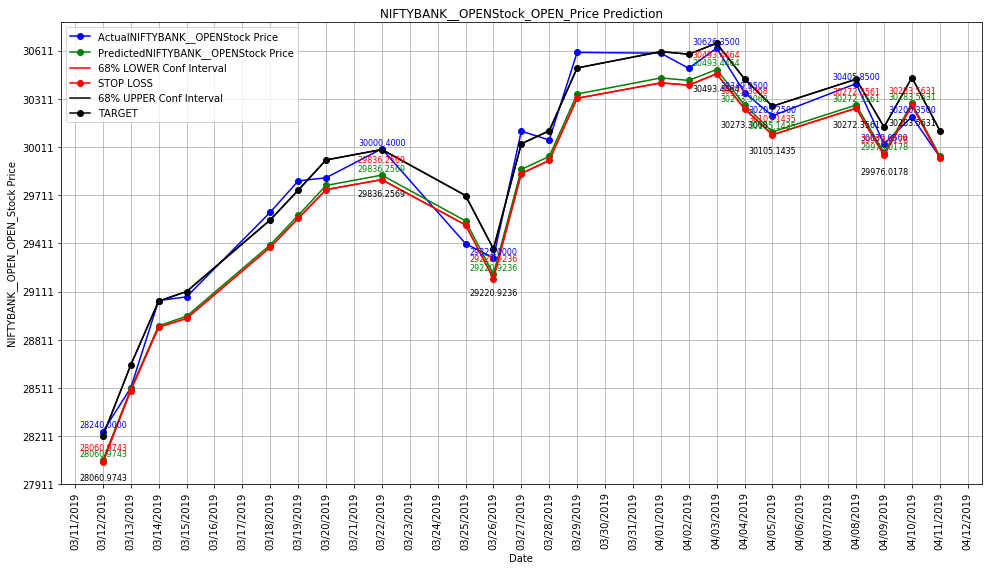

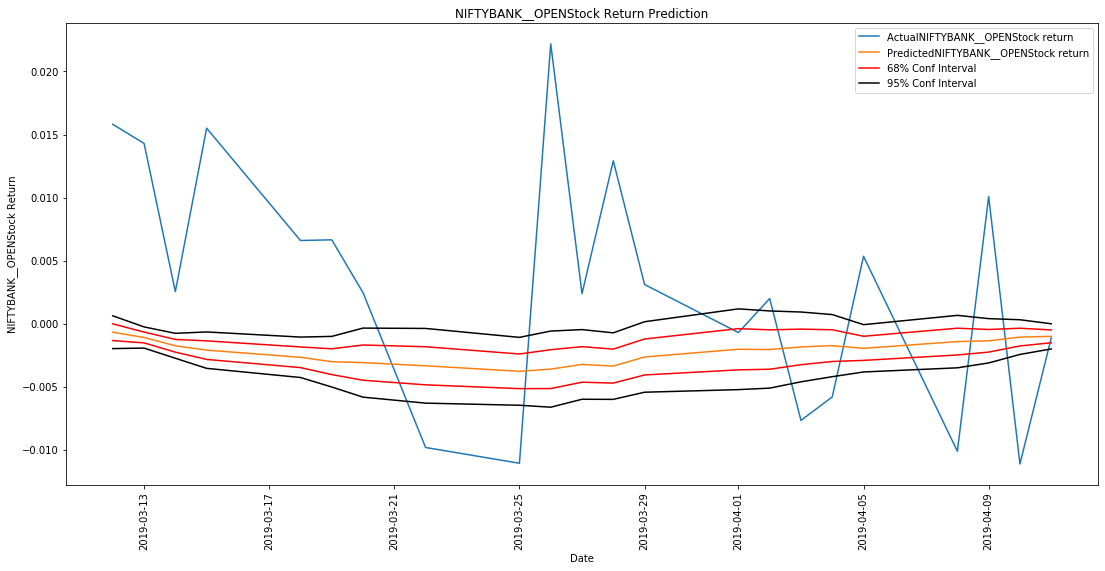

          date      type  absolute_price  dropdown_absolute  low_price  \
0   2019-03-12       BUY    28240.000000               0.00   28210.60   
1   2019-03-13  NOT SELL    28511.500000             271.50   28436.00   
2   2019-03-14  NOT SELL    29055.550000             544.05   28862.25   
3   2019-03-15  NOT SELL    29078.750000              23.20   29040.25   
4   2019-03-18  NOT SELL    29605.050000             526.30   29371.90   
5   2019-03-19  NOT SELL    29800.000000             194.95   29502.90   
6   2019-03-20  NOT SELL    29819.950000              19.95   29704.00   
7   2019-03-22      SELL    30000.400000             180.45   29572.00   
8   2019-03-25   NOT BUY    29410.000000               0.00   29211.30   
9   2019-03-26       BUY    29321.000000               0.00   29300.00   
10  2019-03-27  NOT SELL    30109.950000             788.95   29780.55   
11  2019-03-28  NOT SELL    30055.000000             -54.95   29928.85   
12  2019-03-29  NOT SELL    30600.0000

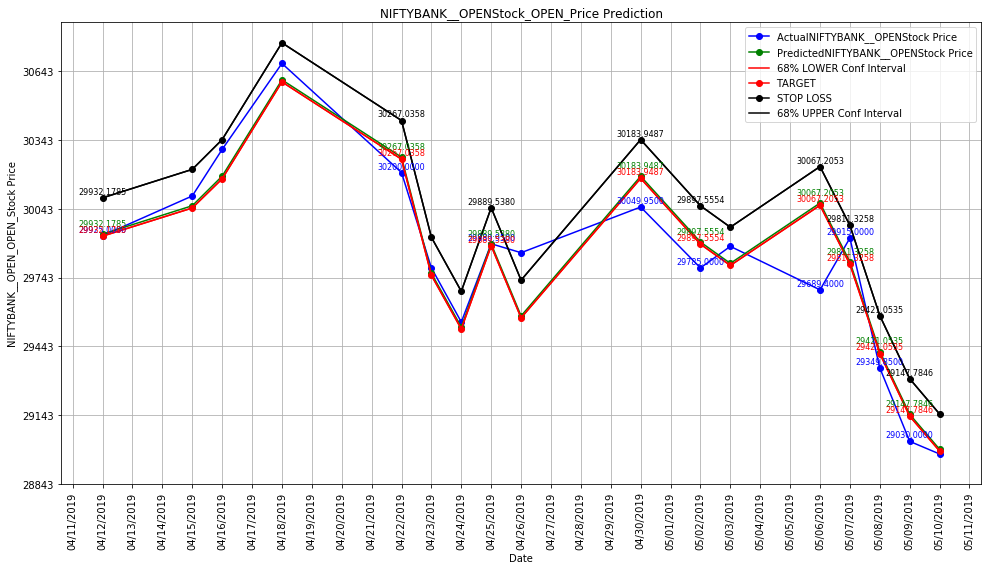

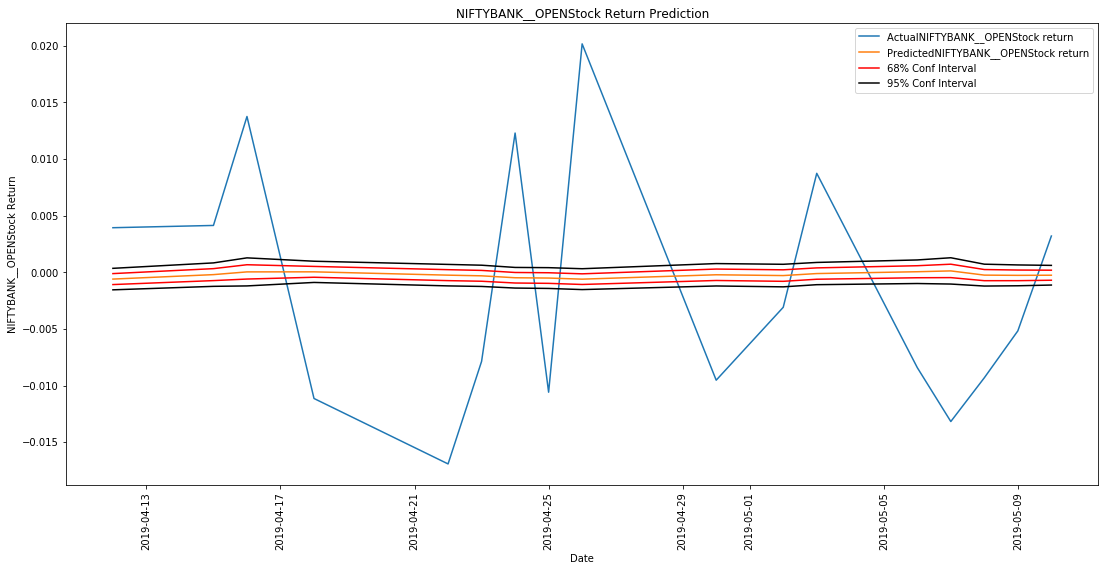

          date      type  absolute_price  dropdown_absolute  high_price  \
0   2019-04-12      SELL    29925.000000                0.0    30150.00   
1   2019-04-12       BUY    29775.303047                0.0    30150.00   
2   2019-04-15  NOT SELL    30098.100000                0.0    30249.00   
3   2019-04-16  NOT SELL    30300.750000                0.0    30678.00   
4   2019-04-18  NOT SELL    30675.000000                0.0    30722.25   
5   2019-04-22      SELL    30200.000000                0.0    30244.90   
6   2019-04-22       BUY    30108.422134                0.0    30244.90   
7   2019-04-23  NOT SELL    29784.900000                0.0    29928.00   
8   2019-04-24  NOT SELL    29549.400000                0.0    29958.00   
9   2019-04-25      SELL    29889.950000                0.0    30060.00   
10  2019-04-25       BUY    29733.068383                0.0    30060.00   
11  2019-04-26  NOT SELL    29851.100000                0.0    30229.70   
12  2019-04-30      SELL 

length matched
20
INCREASING TREND
21 21 21 21
iterate at
10.276081612300375
Not Buy at
0
iterate to
1
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.266427828229292
Not Buy at
1
iterate to
2
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.277119657700908
Buy at
2
29060.049999999996
Sell at
2
iterate to
3
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.262557875263003
Not Buy at
3
iterate to
4
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.272805485995386
Not Buy at
4
iterate to
5
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.315102047681034
Buy at
5
30185.049999999974
Sell at
6
30860.000000000004
**** DRAWDOWN MEASURE ****
-0.012843231179912845 -393.4398511983412 -427.31410825344375 674.9500000000298
iterate to
7
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.323021561239752
Buy at
7
30425.050000000025
Sell at
8
30900.0
**** DRAWDOWN MEASURE ****
-0.

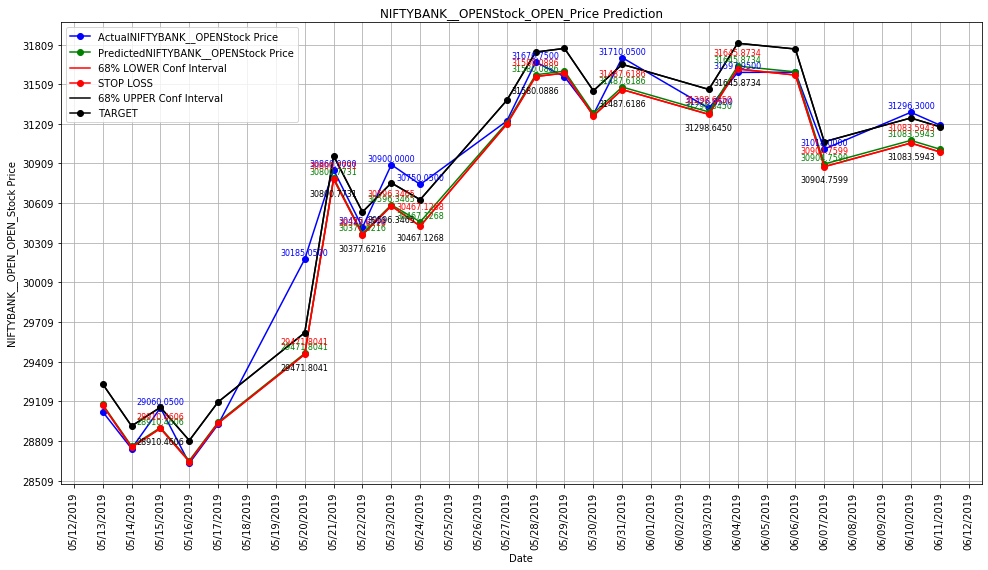

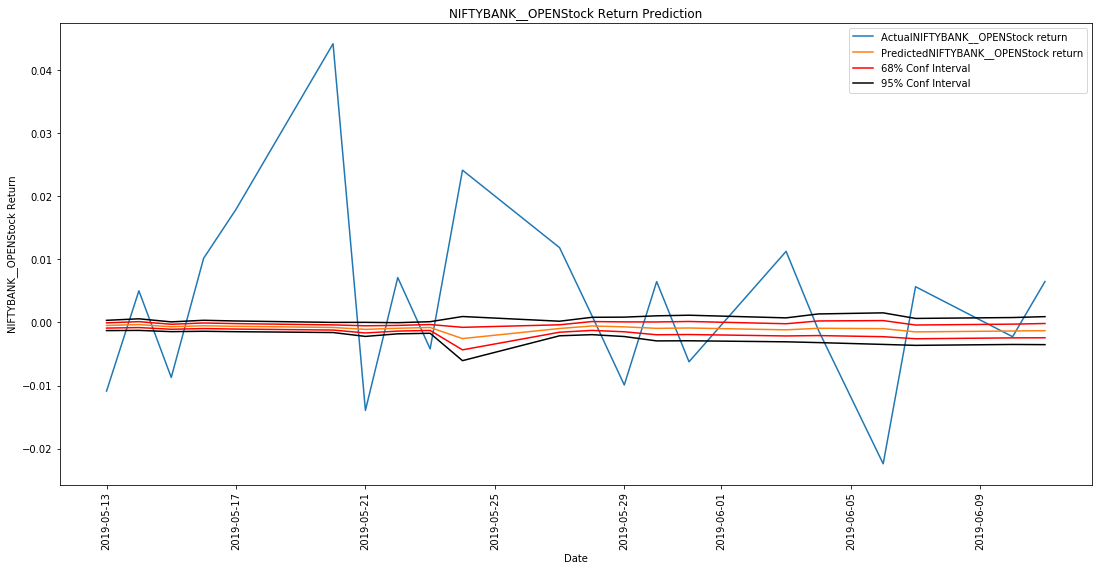

          date      type  absolute_price  dropdown_absolute  low_price  \
0   2019-05-13   NOT BUY    29029.900000               0.00   28712.40   
1   2019-05-14   NOT BUY    28751.000000               0.00   28700.00   
2   2019-05-15       BUY    29060.050000               0.00   28594.65   
3   2019-05-15      SELL    28757.986861               0.00   28594.65   
4   2019-05-16   NOT BUY    28639.950000               0.00   28571.00   
5   2019-05-17   NOT BUY    28934.950000               0.00   28880.10   
6   2019-05-20       BUY    30185.050000               0.00   30060.50   
7   2019-05-21      SELL    30860.000000             674.95   30315.10   
8   2019-05-22       BUY    30425.050000               0.00   30350.00   
9   2019-05-23      SELL    30900.000000             474.95   30332.75   
10  2019-05-24       BUY    30750.050000               0.00   30580.05   
11  2019-05-27  NOT SELL    31229.950000             479.90   31175.10   
12  2019-05-28  NOT SELL    31676.7500

length matched
21
INCREASING TREND
22 22 22 22
iterate at
10.348814194069423
Not Buy at
0
iterate to
1
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.338123037944072
Not Buy at
1
iterate to
2
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.340293046443996
Not Buy at
2
iterate to
3
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.328722607667915
Not Buy at
3
iterate to
4
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.32055014903983
Buy at
4
30349.950000000026
not Sell at
5
30506.349999999973
not Sell at
6
30377.849999999977
Sell at
7
30699.95000000002
**** DRAWDOWN MEASURE ****
-0.004336087835872839 -132.85248751790508 -129.66237712496667 322.1000000000422
iterate to
8
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.331204899569634
Buy at
8
30675.050000000017
not Sell at
9
30589.950000000023
Sell at
9
iterate to
10
-----------------ITERATE TO NEXT TRADE-----------------
iterate

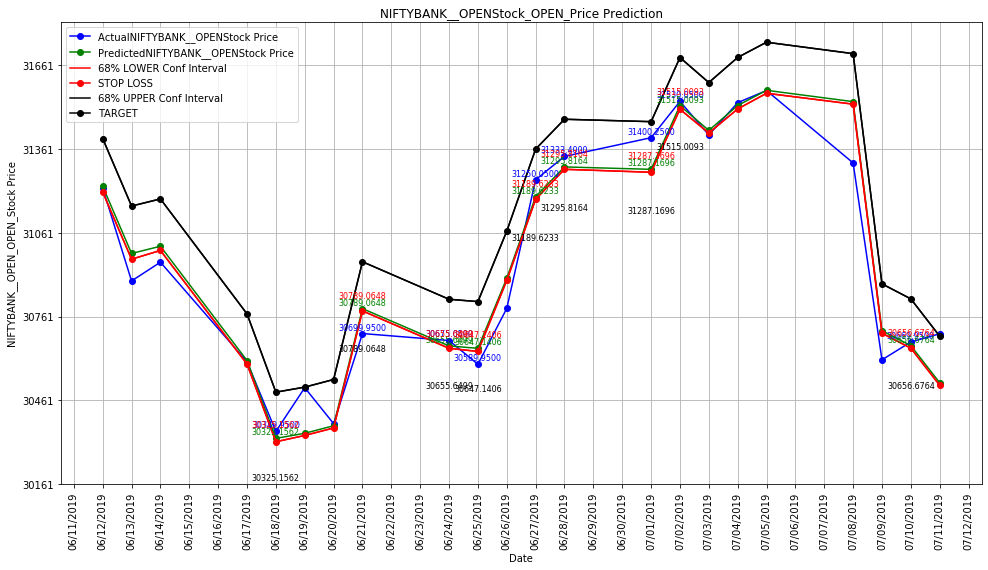

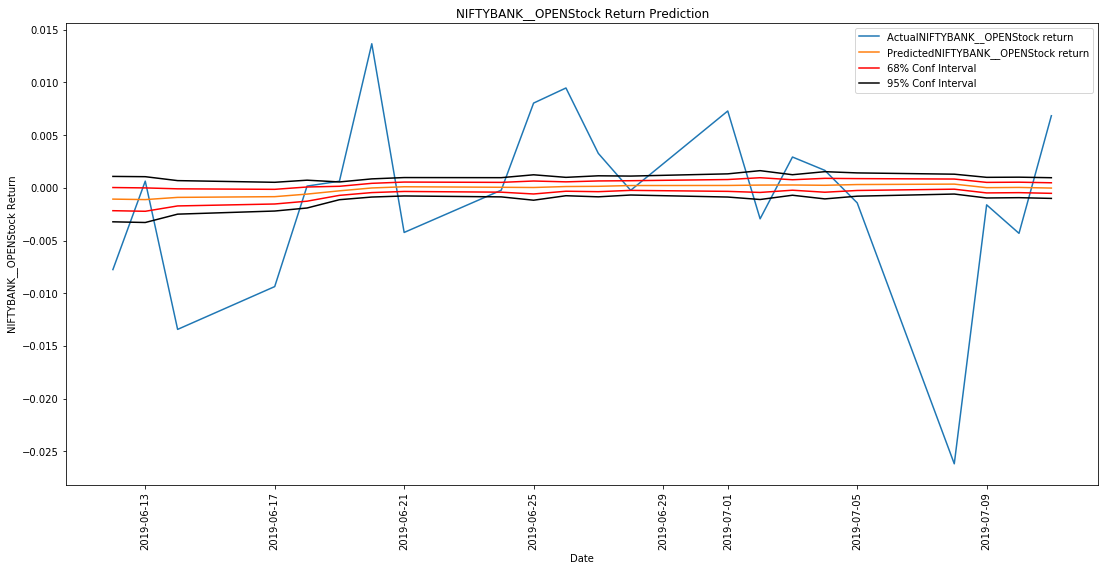

          date      type  absolute_price  dropdown_absolute  low_price  \
0   2019-06-12   NOT BUY    31220.000000               0.00   30906.20   
1   2019-06-13   NOT BUY    30888.000000               0.00   30665.00   
2   2019-06-14   NOT BUY    30955.100000               0.00   30503.15   
3   2019-06-17   NOT BUY    30599.000000               0.00   30306.00   
4   2019-06-18       BUY    30349.950000               0.00   30200.00   
5   2019-06-19  NOT SELL    30506.350000             156.40   30213.90   
6   2019-06-20  NOT SELL    30377.850000            -128.50   30276.00   
7   2019-06-21      SELL    30699.950000             322.10   30515.00   
8   2019-06-24       BUY    30675.050000               0.00   30533.65   
9   2019-06-25  NOT SELL    30589.950000             -85.10   30480.00   
10  2019-06-25      SELL    30481.033435             -85.10   30480.00   
11  2019-06-26   NOT BUY    30790.000000               0.00   30779.35   
12  2019-06-27       BUY    31250.0500

length matched
20
DECREASING TREND
21 21 21 21
iterate at
0 0
10.333578604345677
Not Sell at
0
iterate to
1
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
1 0
10.331936497034668
Not Sell at
1
iterate to
2
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
2 0
10.325811416516322
Not Sell at
2
iterate to
3
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
3 0
10.32790525356098
Sell at
3
Buy at
3
iterate to
4
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
4 0
10.33159276176934
Sell at
4
Buy at
4
iterate to
5
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
5 0
10.326137485398393
Not Sell at
5
iterate to
6
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
6 0
10.297217404425872
Sell at
6
Buy at
6
iterate to
7
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
7 0
10.289256627666736
Not Sell at
7
iterate to
8
-----------------ITERATE TO NEXT TRADE-----------------
iter

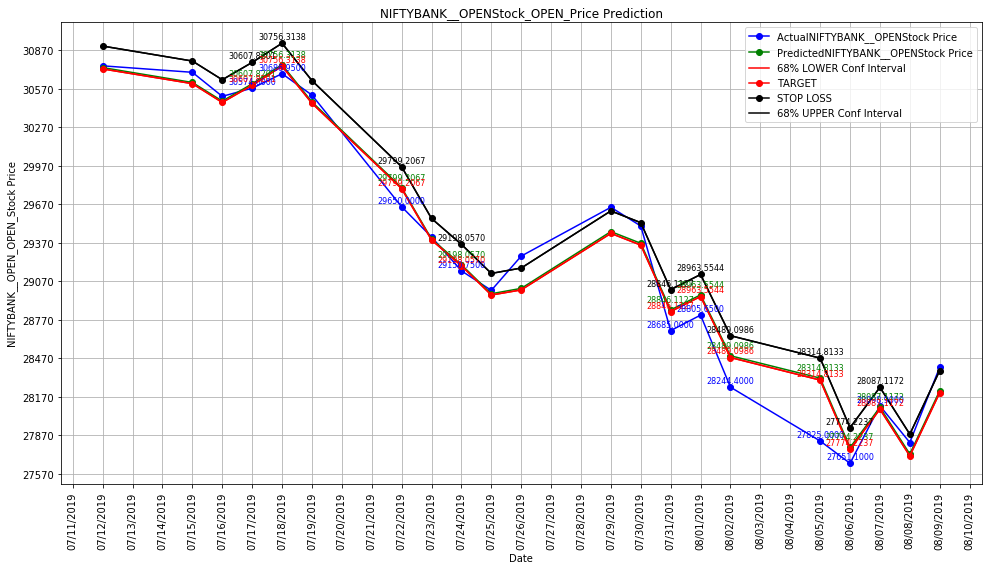

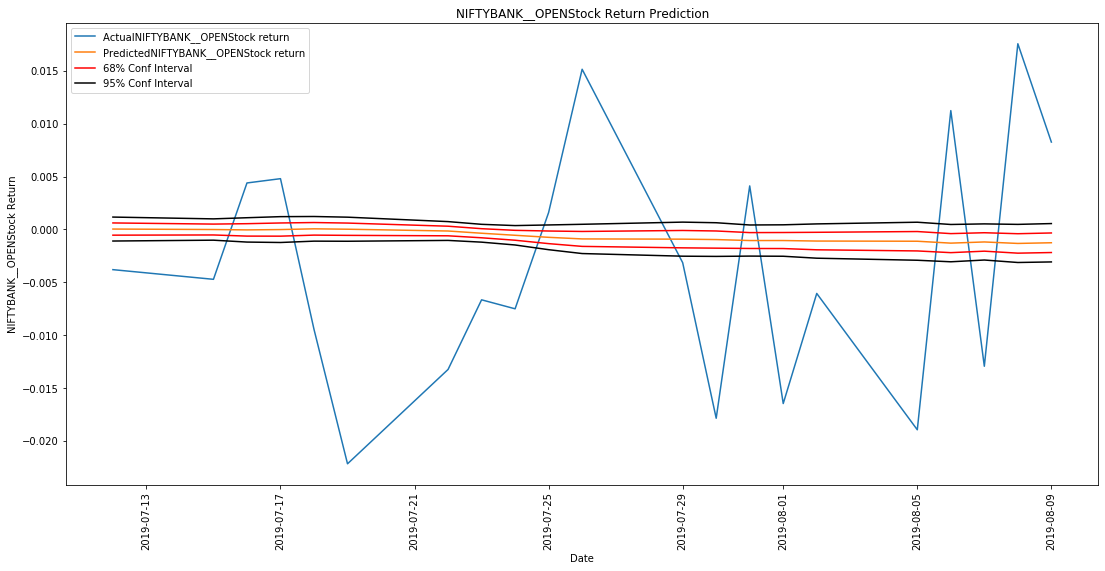

          date      type  absolute_price  dropdown_absolute  high_price  \
0   2019-07-12  NOT SELL    30747.950000                0.0    30848.80   
1   2019-07-15  NOT SELL    30697.500000                0.0    30699.95   
2   2019-07-16  NOT SELL    30510.050000                0.0    30650.00   
3   2019-07-17      SELL    30574.000000                0.0    30778.00   
4   2019-07-17       BUY    30441.845262                0.0    30778.00   
5   2019-07-18      SELL    30686.950000                0.0    30745.00   
6   2019-07-18       BUY    30589.561701                0.0    30745.00   
7   2019-07-19  NOT SELL    30520.000000                0.0    30534.65   
8   2019-07-22      SELL    29650.000000                0.0    29698.65   
9   2019-07-22       BUY    29637.824111                0.0    29698.65   
10  2019-07-23  NOT SELL    29414.900000                0.0    29439.35   
11  2019-07-24      SELL    29150.750000                0.0    29292.00   
12  2019-07-24       BUY 

length matched
18
DECREASING TREND
19 19 19 19
iterate at
0 0
10.254142663584368
Sell at
0
Buy at
0
iterate to
1
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
1 0
10.234593631337335
Not Sell at
1
iterate to
2
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
2 0
10.238172478583245
Sell at
2
Buy at
2
iterate to
3
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
3 0
10.251856597801657
Not Sell at
3
iterate to
4
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
4 0
10.247795084332838
Not Sell at
4
iterate to
5
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
5 0
10.241754606080814
Not Sell at
5
iterate to
6
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
6 0
10.229729061853906
Sell at
6
Buy at
6
iterate to
7
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
7 0
10.199695674707343
Sell at
7
Buy at
7
iterate to
8
-----------------ITERATE TO NEXT TRADE---------------

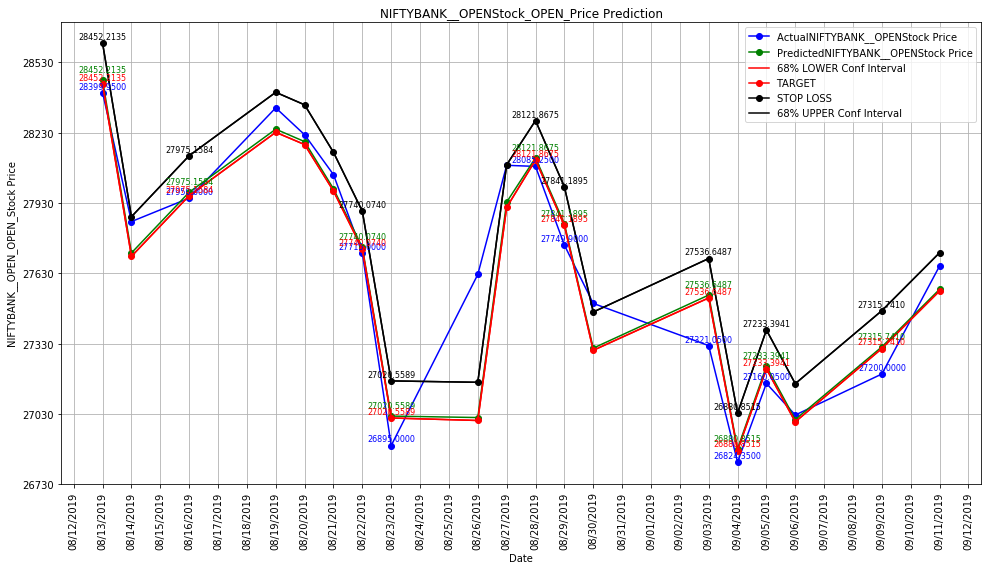

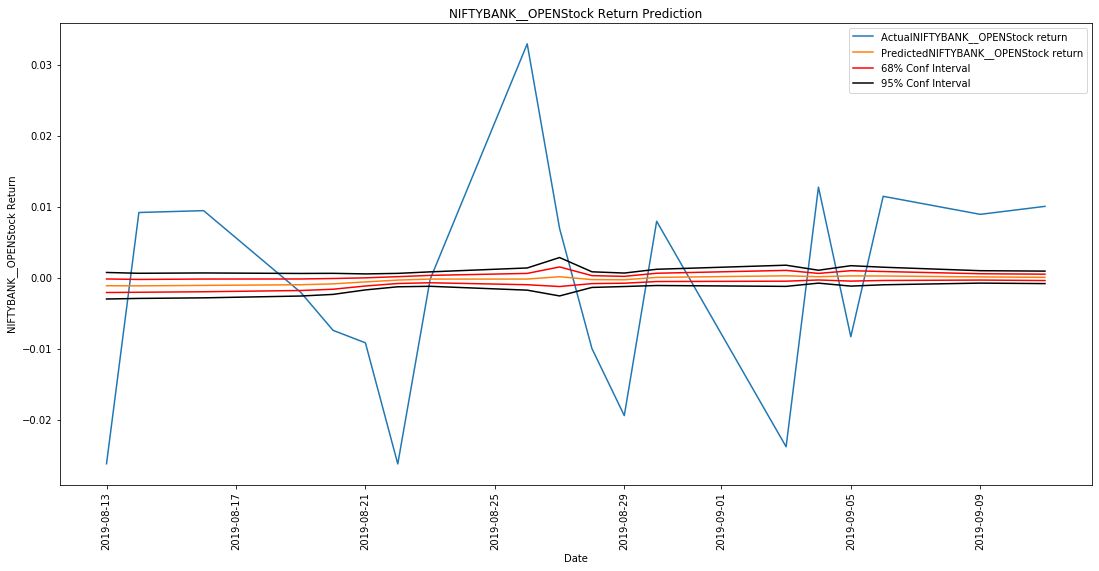

          date      type  absolute_price  dropdown_absolute  high_price  \
0   2019-08-13      SELL    28399.950000                0.0    28490.00   
1   2019-08-13       BUY    28294.532379                0.0    28490.00   
2   2019-08-14  NOT SELL    27850.150000                0.0    28149.00   
3   2019-08-16      SELL    27950.000000                0.0    28310.00   
4   2019-08-16       BUY    27820.131405                0.0    28310.00   
5   2019-08-19  NOT SELL    28335.100000                0.0    28485.30   
6   2019-08-20  NOT SELL    28220.250000                0.0    28220.40   
7   2019-08-21  NOT SELL    28050.300000                0.0    28129.95   
8   2019-08-22      SELL    27715.000000                0.0    27746.05   
9   2019-08-22       BUY    27586.896702                0.0    27746.05   
10  2019-08-23      SELL    26895.000000                0.0    27250.00   
11  2019-08-23       BUY    26871.398845                0.0    27250.00   
12  2019-08-26  NOT SELL 

length matched
19
INCREASING TREND
20 20 20 20
iterate at
10.234791097311
Buy at
0
27855.650000000012
not Sell at
1
27749.950000000015
Sell at
1
iterate to
2
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.232847053520137
Not Buy at
2
iterate to
3
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.232787702549956
Not Buy at
3
iterate to
4
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.215559142869232
Buy at
4
27325.050000000003
Sell at
5
27175.000000000015
**** DRAWDOWN MEASURE ****
-0.015465016781635102 -417.1307396009597 -410.9270567295564 -150.04999999998836
iterate to
6
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.1983916085714
Buy at
6
26859.949999999993
not Sell at
7
29996.50000000001
Sell at
8
30513.999999999996
**** DRAWDOWN MEASURE ****
-0.011982802083675158 -364.6020149994697 -288.95994184556463 517.4999999999854
iterate to
9
-----------------ITERATE TO NEXT TRADE-----------------
iterate

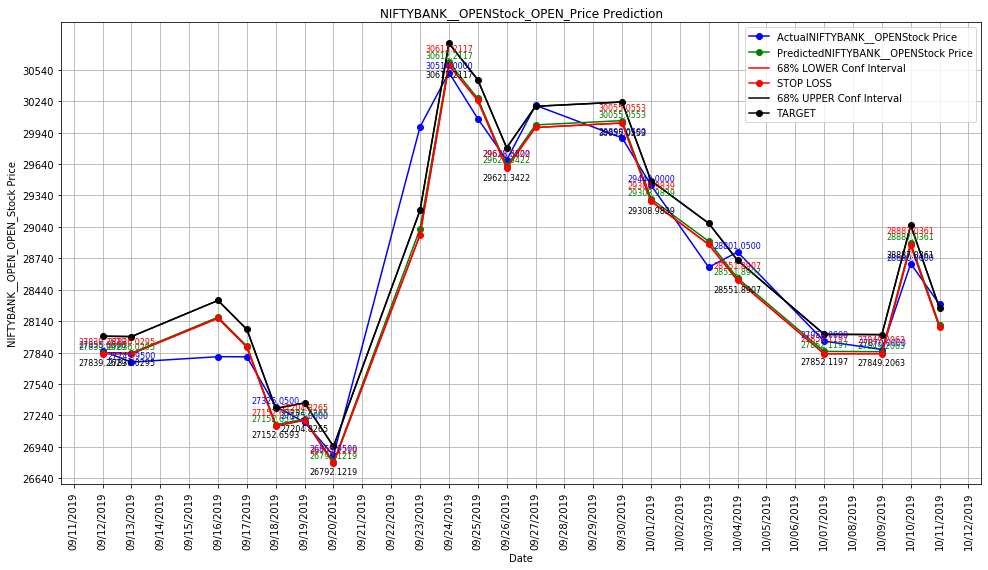

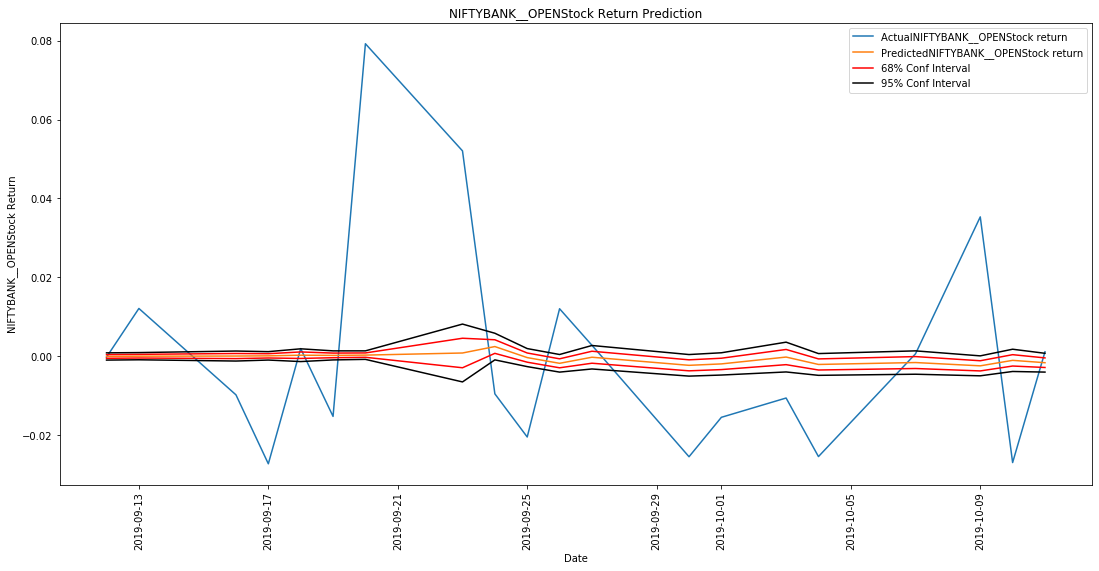

          date      type  absolute_price  dropdown_absolute  low_price  \
0   2019-09-12       BUY    27855.650000               0.00   27770.50   
1   2019-09-13  NOT SELL    27749.950000            -105.70   27585.40   
2   2019-09-13      SELL    27679.553304            -105.70   27585.40   
3   2019-09-16   NOT BUY    27801.550000               0.00   27801.55   
4   2019-09-17   NOT BUY    27799.900000               0.00   27079.00   
5   2019-09-18       BUY    27325.050000               0.00   27127.15   
6   2019-09-19      SELL    27175.000000            -150.05   26683.10   
7   2019-09-20       BUY    26859.950000               0.00   26750.60   
8   2019-09-23  NOT SELL    29996.500000            3136.55   29591.00   
9   2019-09-24      SELL    30514.000000             517.50   29923.25   
10  2019-09-25   NOT BUY    30073.950000               0.00   29511.00   
11  2019-09-26       BUY    29678.650000               0.00   29676.40   
12  2019-09-27  NOT SELL    30201.0000

length matched
19
INCREASING TREND
20 20 20 20
iterate at
10.25125115818194
Buy at
0
28317.949999999993
not Sell at
1
28300.000000000015
not Sell at
2
28720.249999999978
Sell at
2
iterate to
3
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.258728969465825
Not Buy at
3
iterate to
4
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.27607127807428
Not Buy at
4
iterate to
5
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.288647907303929
Buy at
5
29397.000000000025
Sell at
5
iterate to
6
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.288749953326773
Not Buy at
6
iterate to
7
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.296373878437432
Buy at
7
29624.999999999993
Sell at
7
iterate to
8
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.284663383369962
Buy at
8
29280.099999999984
Sell at
8
iterate to
9
-----------------ITERATE TO NEXT TRADE-----------------
itera

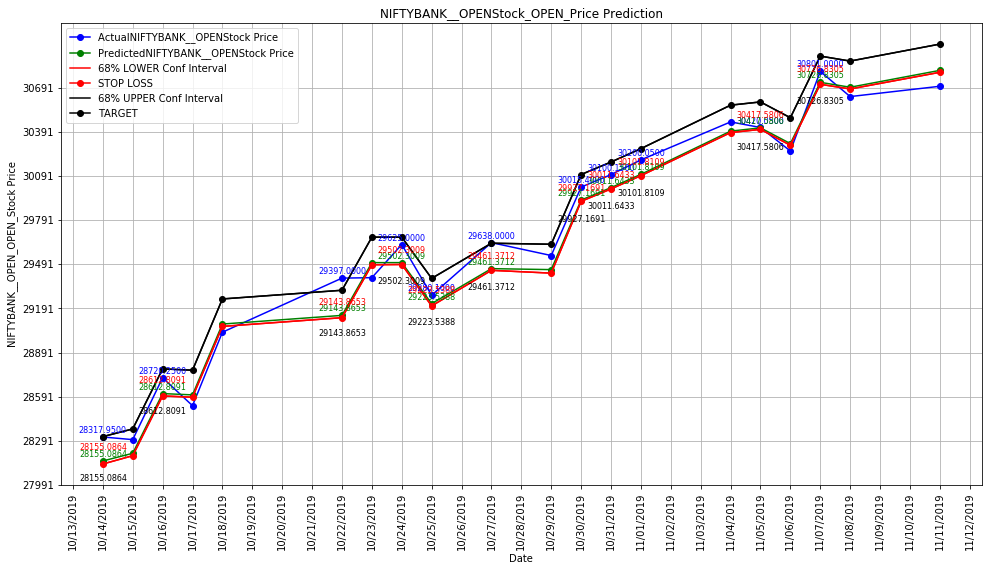

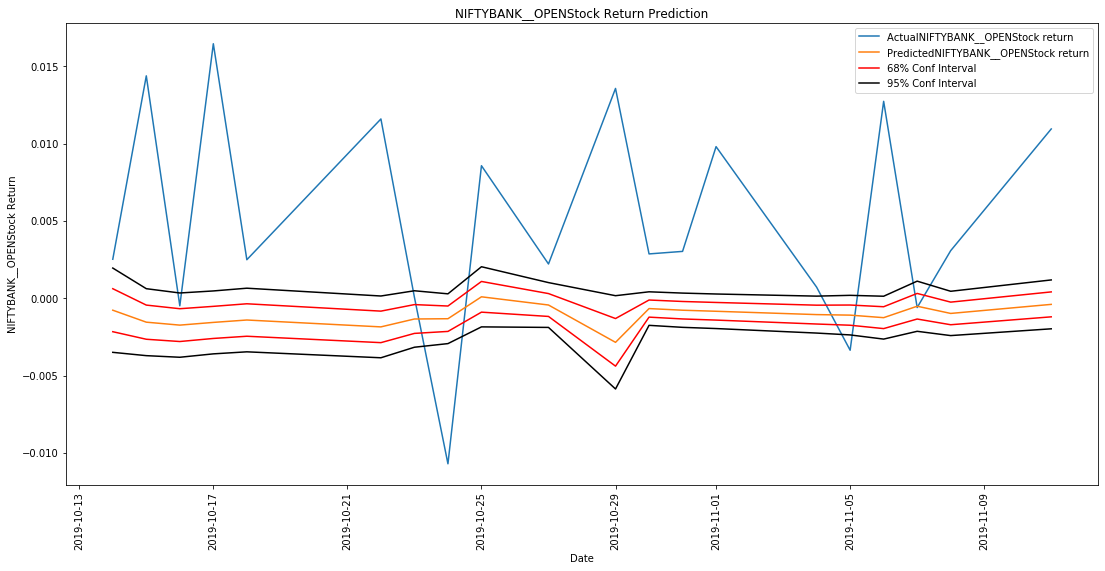

          date      type  absolute_price  dropdown_absolute  low_price  \
0   2019-10-14       BUY    28317.950000               0.00   28082.85   
1   2019-10-15  NOT SELL    28300.000000             -17.95   28251.00   
2   2019-10-16  NOT SELL    28720.250000             420.25   28321.15   
3   2019-10-16      SELL    28446.126141             420.25   28321.15   
4   2019-10-17   NOT BUY    28530.500000               0.00   28530.50   
5   2019-10-18   NOT BUY    29029.600000               0.00   28903.05   
6   2019-10-22       BUY    29397.000000               0.00   28851.40   
7   2019-10-22      SELL    28974.122728               0.00   28851.40   
8   2019-10-23   NOT BUY    29400.000000               0.00   29122.00   
9   2019-10-24       BUY    29625.000000               0.00   29020.95   
10  2019-10-24      SELL    29330.387841               0.00   29020.95   
11  2019-10-25       BUY    29280.100000               0.00   28912.60   
12  2019-10-25      SELL    29052.9826

length matched
20
INCREASING TREND
21 21 21 21
iterate at
10.344446887783251
Not Buy at
0
iterate to
1
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.328101479483053
Not Buy at
1
iterate to
2
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.338582657762425
Buy at
2
30902.2
Sell at
3
31151.999999999978
**** DRAWDOWN MEASURE ****
-0.0006561329864123167 -20.449451640633388 -34.46039894116312 249.79999999997744
iterate to
4
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.343674486913875
Buy at
4
31059.950000000008
not Sell at
5
31349.99999999999
not Sell at
6
31299.94999999998
Sell at
7
31248.19999999999
**** DRAWDOWN MEASURE ****
-0.005509850322015453 -171.44398233041753 -201.6077278134207 -51.749999999989086
iterate to
8
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.344323021979624
Not Buy at
8
iterate to
9
-----------------ITERATE TO NEXT TRADE-----------------
iterate at
10.361548273313806
Buy at


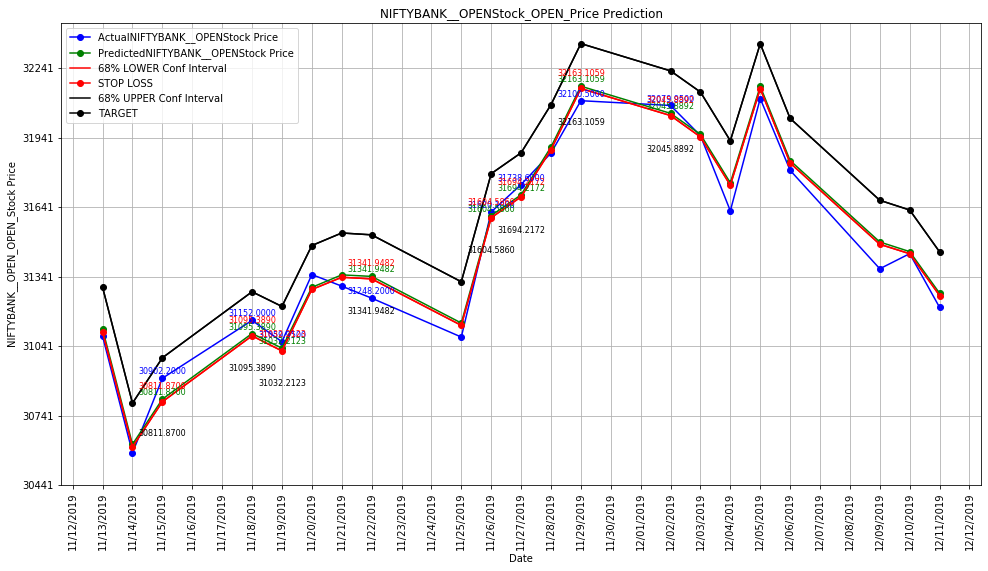

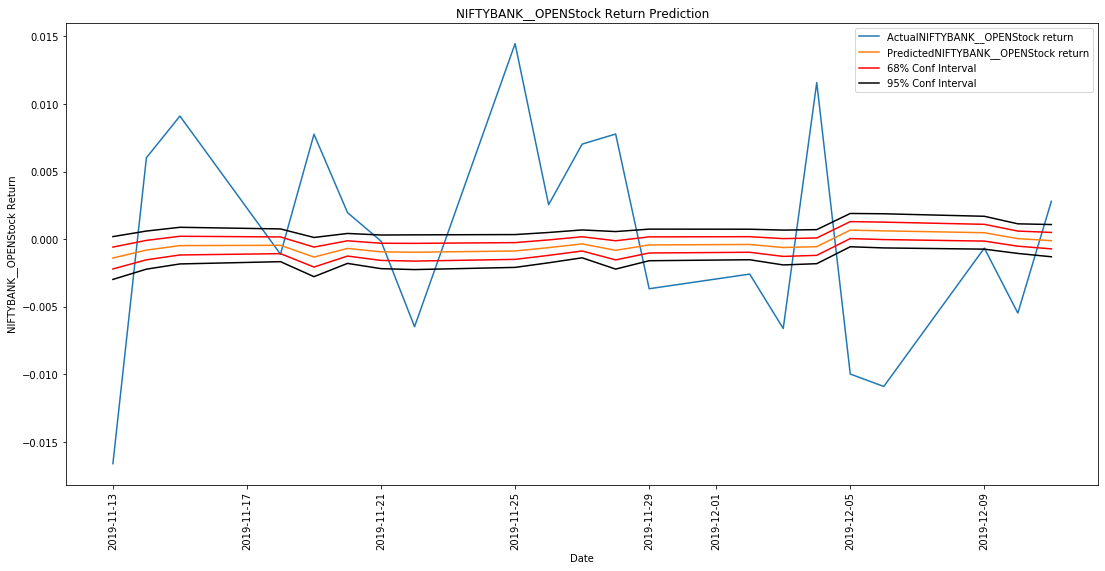

          date      type  absolute_price  dropdown_absolute  low_price  \
0   2019-11-13   NOT BUY    31083.950000               0.00   30538.80   
1   2019-11-14   NOT BUY    30580.000000               0.00   30361.35   
2   2019-11-15       BUY    30902.200000               0.00   30859.60   
3   2019-11-18      SELL    31152.000000             249.80   30900.10   
4   2019-11-19       BUY    31059.950000               0.00   30950.00   
5   2019-11-20  NOT SELL    31350.000000             290.05   31184.55   
6   2019-11-21  NOT SELL    31299.950000             -50.05   31223.60   
7   2019-11-22      SELL    31248.200000             -51.75   31023.35   
8   2019-11-25   NOT BUY    31080.100000               0.00   31049.05   
9   2019-11-26       BUY    31620.100000               0.00   31411.00   
10  2019-11-26      SELL    31424.774335               0.00   31411.00   
11  2019-11-27       BUY    31738.600000               0.00   31705.00   
12  2019-11-28  NOT SELL    31874.2500

In [11]:
df=algo.find_results(12)

In [7]:
print (df.P_L_amount_absolute_term.sum())
df

9591.505115635075


,train_time_period,test_time_period,P_L,number_of_trades,P_L_amount_absolute_term,trend
0,2016-12-11:2018-12-11,2018-12-12to2019-01-11,LOSS,4,-78.152140,INCREASING TREND
1,2017-01-11:2019-01-11,2019-01-12to2019-02-11,PROFIT,19,3552.628466,DECREASING TREND
2,2017-02-11:2019-02-11,2019-02-12to2019-03-11,PROFIT,2,798.600000,INCREASING TREND
3,2017-03-11:2019-03-11,2019-03-12to2019-04-11,PROFIT,3,1136.050000,INCREASING TREND
4,2017-04-11:2019-04-11,2019-04-12to2019-05-11,PROFIT,12,561.676328,DECREASING TREND
5,2017-05-11:2019-05-11,2019-05-12to2019-06-11,PROFIT,3,1484.300000,INCREASING TREND
6,2017-06-11:2019-06-11,2019-06-12to2019-07-11,LOSS,2,-35.100000,INCREASING TREND
7,2017-07-11:2019-07-11,2019-07-12to2019-08-11,PROFIT,17,1085.233301,DECREASING TREND
8,2017-08-11:2019-08-11,2019-08-12to2019-09-11,PROFIT,13,537.384162,DECREASING TREND
9,2017-09-11:2019-09-11,2019-09-12to2019-10-11,LOSS,4,-453.500000,INCREASING TREND
